<img src="https://upload.wikimedia.org/wikipedia/en/0/0f/Ola_Cabs_logo.svg" width="300"/>

# **OLA ENSEMBLE LEARNING**
###Analyzed by Aditya Das

## **Problem Statement**

Ola, a leading ride-hailing company, faces a significant challenge in retaining its drivers. High attrition rates among drivers lead to increased recruitment costs, lowered driver morale, and operational inefficiencies. Since drivers can easily switch to competitors, such as Uber, depending on pay rates or incentives, reducing driver churn has become a critical business concern.

The cost of acquiring new drivers is significantly higher than retaining existing ones, making it essential to identify patterns and factors that influence driver attrition. By predicting which drivers are likely to leave, Ola can implement targeted interventions to improve retention, enhance driver satisfaction, and ultimately reduce costs.

This project aims to build a predictive model to identify drivers at risk of leaving the company. Using demographic, performance, and tenure-related data, the model will help Ola take preemptive measures to reduce attrition and improve driver engagement.

Key objectives include:
1. Identifying the key factors contributing to driver attrition.
2. Predicting the likelihood of a driver leaving based on historical data.
3. Providing actionable insights and recommendations to help Ola retain its drivers.

The model will utilize advanced machine learning techniques, including ensemble learning methods like Bagging and Boosting, to ensure high prediction accuracy. Additionally, it will address class imbalance issues inherent in the dataset, as only a subset of drivers are likely to leave, while the majority will remain.

## **Importing packages**

In [ ]:
pip install scikit-learn

In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,accuracy_score, ConfusionMatrixDisplay\
,recall_score,precision_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# @title Downloading and reading Dataset
!gdown 1cm0gdTtymY8vwzru7YtSWJrfDP7A-bnf

Downloading...
From: https://drive.google.com/uc?id=1cm0gdTtymY8vwzru7YtSWJrfDP7A-bnf
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 28.1MB/s]


In [ ]:
df=pd.read_csv('ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [ ]:
df.shape

(19104, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488



## **Dataset Overview**:
- **Total entries**: 19,104 rows, indicating a substantial amount of data on driver performance and demographics over time.
- **Total columns**: 14 columns, capturing various details like driver demographics, income, employment details, and performance ratings.

### **Columns Breakdown**:
1. **`Unnamed: 0`**:
   - This seems like an unnecessary index column, likely generated during file export. It can be safely dropped.
   
2. **`MMM-YY`** (Reporting Date):
   - Data type: `object` (string).
   - Should be converted to a proper `datetime` format for easier analysis and aggregation over time.

3. **`Driver_ID`**:
   - Unique identifier for drivers.
   - Likely needs to be used for grouping and aggregation, especially for performance tracking over time.

4. **`Age`**:
   - 19,043 non-null values, meaning 61 entries have missing age values.
   - Since this is a crucial demographic feature, missing values need to be handled carefully, potentially through imputation.

5. **`Gender`**:
   - 19,052 non-null values, with 52 missing values.
   - Gender is encoded as `0` for male and `1` for female, but the missing values need to be addressed.
   
6. **`City`**:
   - Categorical feature that identifies the city where drivers operate.
   - No missing values, which is good. However, this column might require encoding for modeling.

7. **`Education_Level`**:
   - Numeric encoding for education: `0` (10+), `1` (12+), `2` (Graduate).
   - No missing values. This feature might influence driver attrition or performance.

8. **`Income`**:
   - Monthly income of the drivers.
   - No missing values, so this can be directly used in the analysis.

9. **`Dateofjoining`**:
   - Date when the driver joined the company.
   - This column is in `object` format and should be converted to a `datetime` format to derive features such as tenure.

10. **`LastWorkingDate`**:
    - Only 1,616 non-null values, meaning most drivers have not left the company yet (likely active drivers).
    - This is a key feature for the target variable (attrition), indicating which drivers have left.

11. **`Joining Designation`**:
    - Coded as integers, representing the designation drivers started with.
    - No missing values.

12. **`Grade`**:
    - Represents the grade of drivers at the time of reporting.
    - No missing values, making this feature useful for performance analysis.

13. **`Total Business Value`**:
    - Represents the total business value drivers brought in a month.
    - No missing values, but the presence of negative values (indicating cancellations or refunds) should be explored further.
  
14. **`Quarterly Rating`**:
    - Ratings of drivers, likely from 1 to 5, with higher ratings being better.
    - No missing values, useful for performance-related analysis.

### **Data Quality Issues**:
1. **Missing values**:
   - `Age`: 61 missing values.
   - `Gender`: 52 missing values.
   - `LastWorkingDate`: 17,488 missing values (these drivers are still active).

2. **Data type conversion**:
   - `MMM-YY` and `Dateofjoining` should be converted to `datetime`.
   - This allows for the creation of derived features such as tenure (time spent with the company).

3. **Duplicate Entries**:
   - Check for duplicate `Driver_ID` entries, especially across different months.
   - Aggregation or deduplication may be needed to analyze each driver uniquely.

4. **Negative Business Value**:
   - Investigate the negative values in the `Total Business Value` column, as they might represent cancellations or deductions.

In [ ]:
df.nunique()

,0
Unnamed: 0,19104
MMM-YY,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Income,2383
Dateofjoining,869
LastWorkingDate,493


In [ ]:
np.any(df.duplicated())

np.False_

'Unnamed: 0' is  serial no feature so no use of this, so dropping this feature.

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [ ]:
df.nunique()

,0
MMM-YY,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Income,2383
Dateofjoining,869
LastWorkingDate,493
Joining Designation,5


In [ ]:
# @title Data Preprocessing
df['MMM-YY']=pd.to_datetime(df['MMM-YY'])
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')
df.rename(columns={'MMM-YY':'Reporting_month'},inplace=True)

In [ ]:
# @title Checking missing values

df.isna().sum()/len(df)*100

,0
Reporting_month,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039
Joining Designation,0.000000


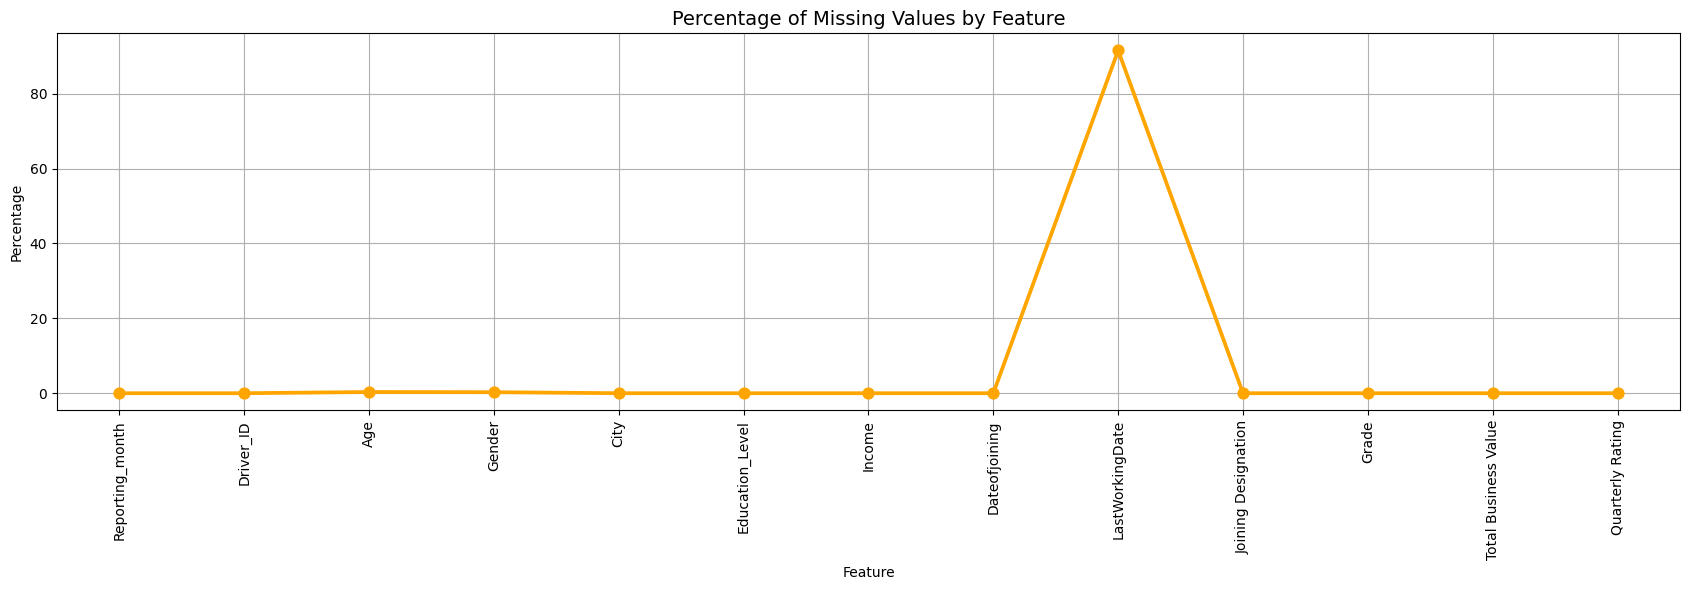

In [ ]:
# Calculate missing value percentage
missing = pd.DataFrame(df.isnull().sum() / len(df) * 100).reset_index()
missing.columns = ['Feature', 'Missing_Percent']

# Plot
plt.figure(figsize=(17, 6))
sns.pointplot(data=missing, x='Feature', y='Missing_Percent', color='orange')
plt.title("Percentage of Missing Values by Feature", fontsize=14)
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# @title Imputing the missing values of Age and Gender

df['Gender'] = df.groupby('Driver_ID')['Gender'].transform(lambda x: x.ffill().bfill())
df['Age'] = df.groupby('Driver_ID')['Age'].transform(lambda x: x.ffill().bfill())

df.isnull().sum()

,0
Reporting_month,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Reporting_month       19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19104 non-null  float64       
 3   Gender                19104 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [ ]:
df.head()

,Reporting_month,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


In [ ]:
# @title Converting categorial features to same datatype

df['Gender']=df['Gender'].astype('category')
df['City']=df['City'].astype('category')
df['Education_Level']=pd.Categorical(df['Education_Level'],categories=[0,1,2],ordered=True)
df['Joining Designation']=pd.Categorical(df['Joining Designation'],categories=[1,2,3,4,5],ordered=True)
df['Grade']=pd.Categorical(df['Grade'],categories=[1,2,3,4,5],ordered=True)

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Reporting_month,19104,2019-12-11 02:09:29.849246464,2019-01-01 00:00:00,2019-06-01 00:00:00,2019-12-01 00:00:00,2020-07-01 00:00:00,2020-12-01 00:00:00,NaN
Driver_ID,19104.0,1415.591133,1.0,710.0,1417.0,2137.0,2788.0,810.705321
Age,19104.0,34.650335,21.0,30.0,34.0,39.0,58.0,6.264453
Income,19104.0,65652.025126,10747.0,42383.0,60087.0,83969.0,188418.0,30914.515344
Dateofjoining,19104,2018-04-28 20:52:54.874371840,2013-04-01 00:00:00,2016-11-29 12:00:00,2018-09-12 00:00:00,2019-11-05 00:00:00,2020-12-28 00:00:00,NaN
LastWorkingDate,1616,2019-12-21 20:59:06.534653696,2018-12-31 00:00:00,2019-06-06 00:00:00,2019-12-20 12:00:00,2020-07-03 00:00:00,2020-12-28 00:00:00,NaN
Total Business Value,19104.0,571662.074958,-6000000.0,0.0,250000.0,699700.0,33747720.0,1128312.218461
Quarterly Rating,19104.0,2.008899,1.0,1.0,2.0,3.0,4.0,1.009832


## Statistical Summary
- **Driver Age**: Mean 34.65 years; range 21 to 58.
- **Income**: Mean 65,652; range 10,747 to 188,418. This much high income in a month is quite impossible for a driver so I am assuming that this driver_id may have some driver group or a company/organisation who have providing drivers and their whole income is shown as single instance.
- **Total Business Value**: Mean 571,662; large variation with a minimum of -6M and maximum of 33.7M.
- **Quarterly Rating**: Mean 2.01; most drivers rated between 1 and 3.
- **Date of Joining**: Median in 2018.
- **Last Working Date**: Median in late 2019 for those who left.
- **MMM-YY** column is for reporting date , it is range only 2019 to 2020 but **dateofjoining**  range is between 2013 to 2020 , **lastworkingdate** range is between 2018 to 2020 that means we have less data for driver joining before and leave as we have data between 2019 to 2020 means two year data only

Straightforward trends with age, income, and ratings, but business value shows high variation.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Reporting_month       19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19104 non-null  float64       
 3   Gender                19104 non-null  category      
 4   City                  19104 non-null  category      
 5   Education_Level       19104 non-null  category      
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  category      
 10  Grade                 19104 non-null  category      
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: category(5), 

In [ ]:
df.describe(include=['object','category']).T

,count,unique,top,freq
Gender,19104.0,2.0,0.0,11103.0
City,19104,29,C20,1008
Education_Level,19104,3,1,6864
Joining Designation,19104,5,1,9831
Grade,19104,5,2,6627


## Categorical Summary
- **Gender**: 2 unique values; **Male (0)** is most common (11,103 occurrences).
- **City**: 29 unique cities; **C20** is the most frequent (1,008 occurrences).
- **Education Level**: 3 categories; **12+ (1)** is the top category (6,864 occurrences).
- **Joining Designation**: 5 roles; **Designation 1** is the most frequent (9,831 occurrences).
- **Grade**: 5 unique grades; **Grade 2** is most common (6,627 occurrences).

This highlights the predominance of males, specific city clusters, and common education and designation patterns.

## Univariate Analysis

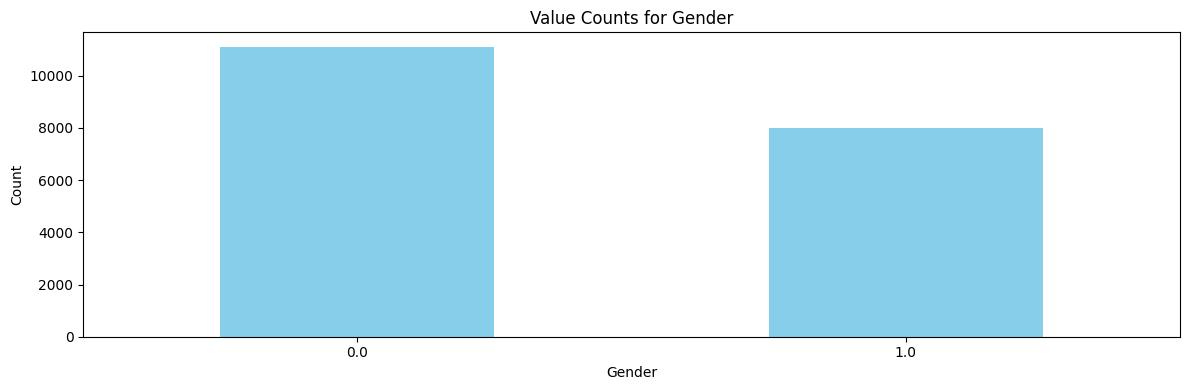

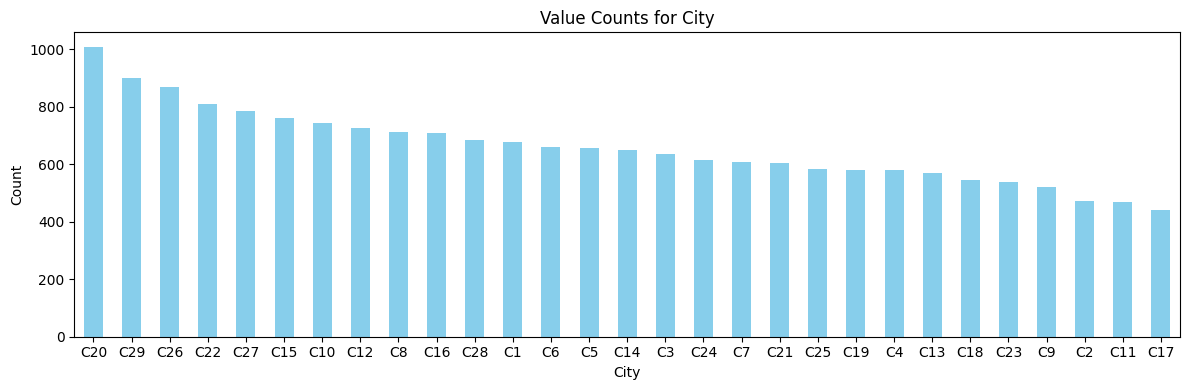

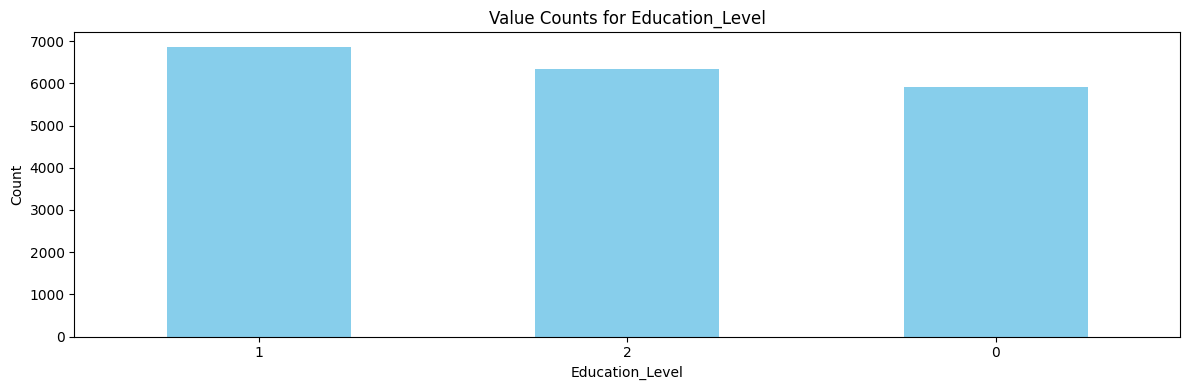

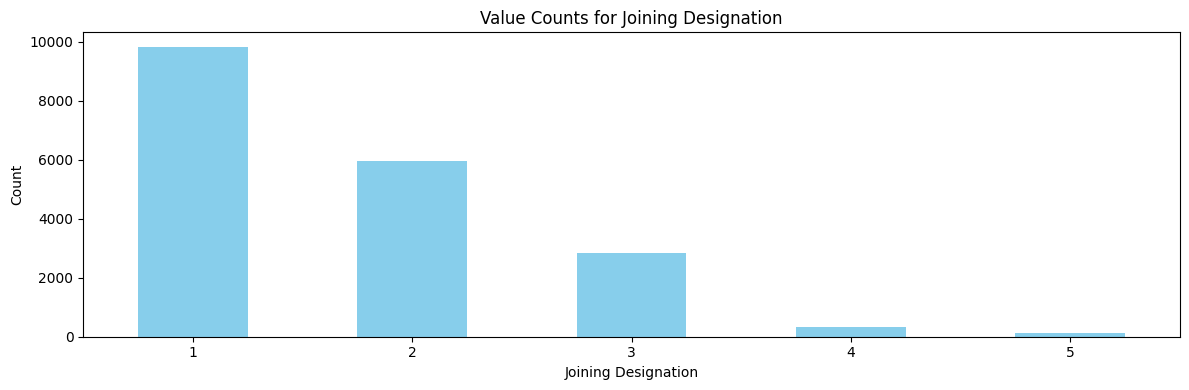

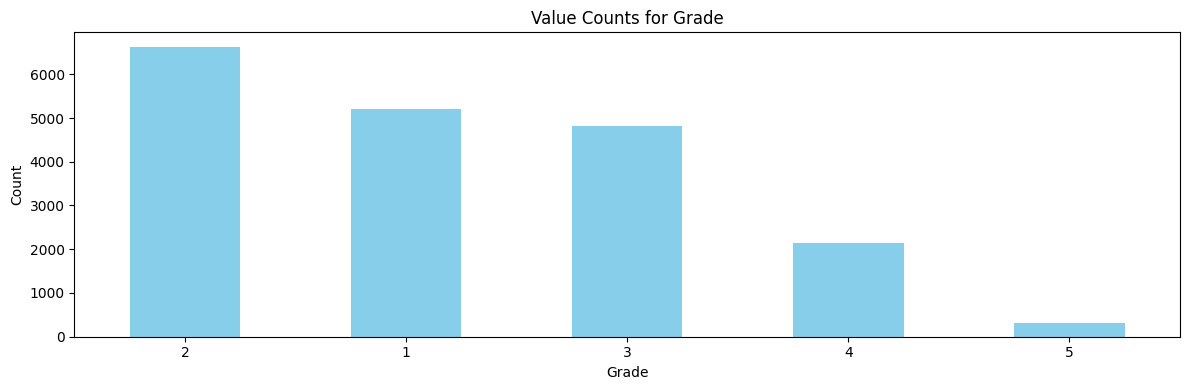

In [ ]:
cat_vars=df.select_dtypes('category')

for col in cat_vars.columns:
    plt.figure(figsize=(12, 4))
    df[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

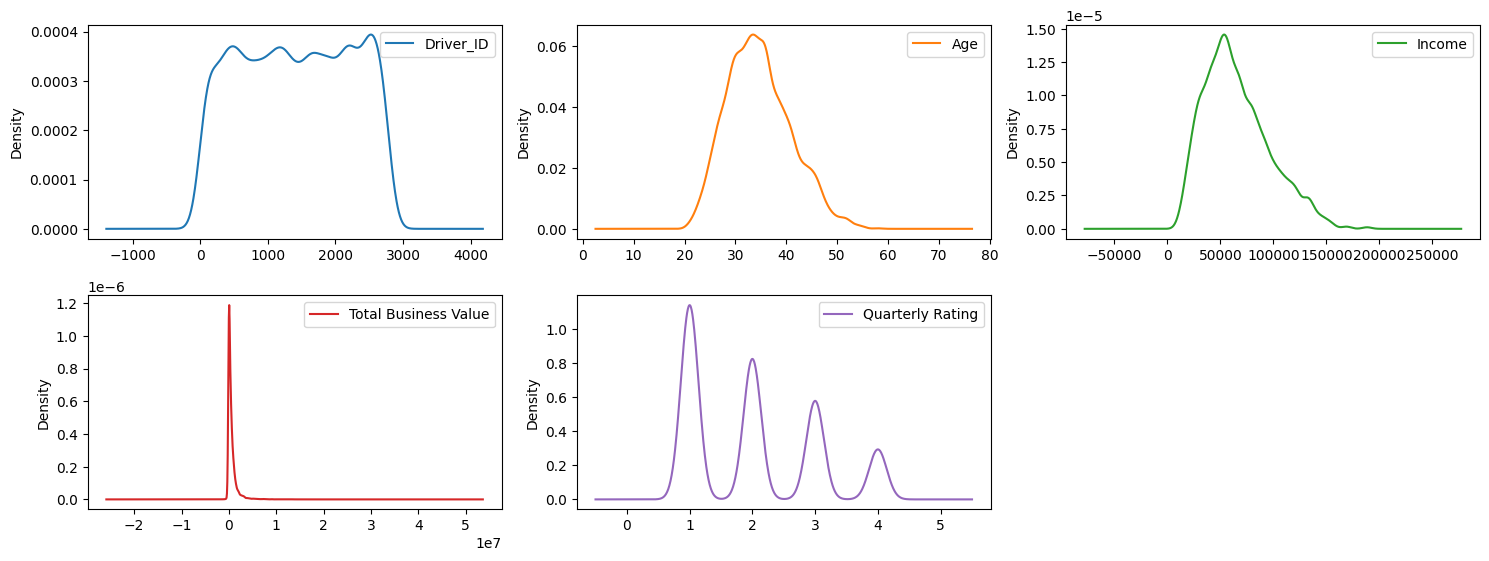

In [ ]:
num_vars=df.select_dtypes(np.number)

plt.rcParams['figure.figsize'] = (15, 8)
num_vars.plot(kind='kde', subplots=True, layout=(3,3),sharex=False)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

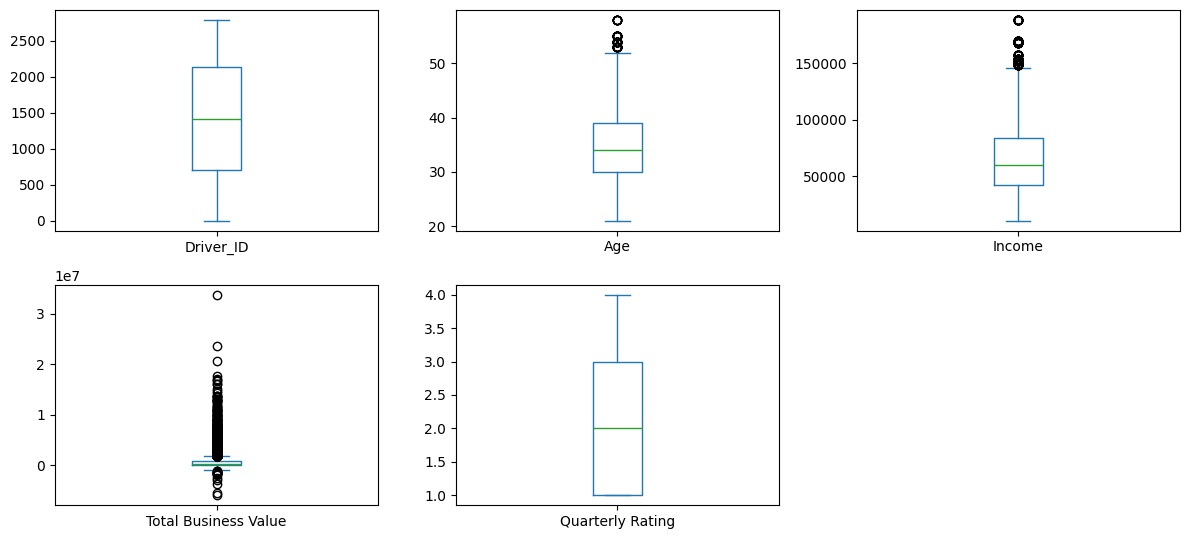

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
num_vars.plot(kind='box', subplots=True, layout=(3,3),sharex=False)
plt.tight_layout()
plt.show()

Though the above plots shows some outliers and distribution type lets confirm them after dealing with duplicate data for drivers

## **Feature Engineering**

In [ ]:
# Creating new feature to get increase or decrease in income and quarterly ratings
df['next_rating']=df.groupby(['Driver_ID'])['Quarterly Rating'].shift(-1)
df['next_Income']=df.groupby(['Driver_ID'])['Income'].shift(-1)

In [ ]:
conditions=[df['next_rating']-df['Quarterly Rating']>0,
            df['next_rating']-df['Quarterly Rating']==0,
            df['next_rating']-df['Quarterly Rating']<0]

choices=[1,0,-1]
df['Ratings_increased']=np.select(conditions,choices,default=0)

In [ ]:
conditions=[df['next_Income']-df['Income']>0,
            df['next_Income']-df['Income']==0,
            df['next_Income']-df['Income']<0]
df['Income_increased']=np.select(conditions,choices,default=0)

In [ ]:
df['Churn']=np.where(df['LastWorkingDate'].isna(),0,1)

## Exploratory Data Analysis

In [ ]:
# Function to print basic useful details for categorial column

def get_column_details(df, column, title):
  print("Details of ",column," column")
  print('*'*50)

  #DataType of column
  print("\nDataType: ",df[column].dtype)
  print('*'*50)

  #Number of unique values
  print("\nUnique values are: ", df[column].nunique())
  print('*'*50)

  #Get Category counts of Column
  print(f"\nCount of Drivers {title} wise:\n")
  print(df[column].value_counts())
  print('*'*50)

  print(f"\nPercentage of Drivers {title} wise:\n")
  print(round(df[column].value_counts(normalize=True)*100,2))
  print('*'*50)



In [ ]:
# @title Reporting Month
get_column_details(df,column='Reporting_month',title='Reporting Month')

Details of  Reporting_month  column
**************************************************

DataType:  datetime64[ns]
**************************************************

Unique values are:  24
**************************************************

Count of Drivers Reporting Month wise:

Reporting_month
2019-01-01    1022
2019-02-01     944
2019-03-01     870
2020-12-01     819
2020-10-01     818
2020-08-01     812
2020-09-01     809
2020-07-01     806
2020-11-01     805
2019-12-01     795
2019-04-01     794
2020-01-01     782
2019-11-01     781
2020-06-01     770
2020-05-01     766
2019-05-01     764
2019-09-01     762
2020-02-01     761
2019-07-01     757
2019-08-01     754
2019-10-01     739
2020-04-01     729
2019-06-01     726
2020-03-01     719
Name: count, dtype: int64
**************************************************

Percentage of Drivers Reporting Month wise:

Reporting_month
2019-01-01    5.35
2019-02-01    4.94
2019-03-01    4.55
2020-12-01    4.29
2020-10-01    4.28
2020-08-01   

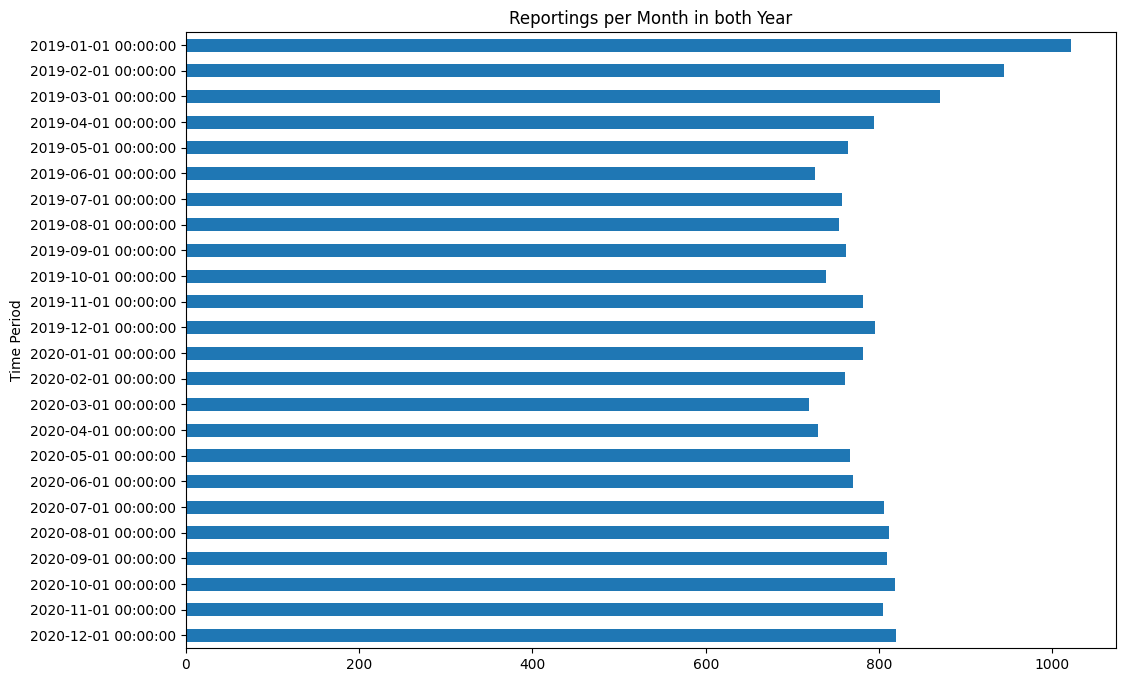

In [ ]:
df['Reporting_month'].value_counts().sort_index().plot(kind='barh')
plt.title('Reportings per Month in both Year')
plt.ylabel('Time Period')
plt.gca().invert_yaxis()
plt.show()

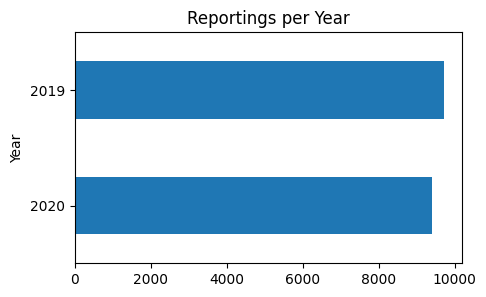

In [ ]:
plt.figure(figsize=(5,3))
df['Reporting_month'].dt.year.value_counts().sort_index().plot(kind='barh')
plt.title('Reportings per Year')
plt.ylabel('Year')
plt.gca().invert_yaxis()
plt.show()

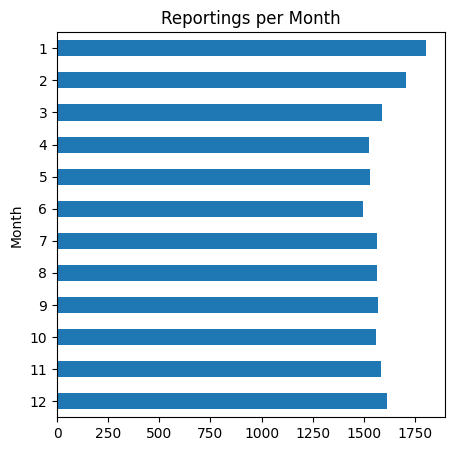

In [ ]:
plt.figure(figsize=(5,5))
df['Reporting_month'].dt.month.value_counts().sort_index().plot(kind='barh')
plt.title('Reportings per Month')
plt.ylabel('Month')
plt.gca().invert_yaxis()
plt.show()

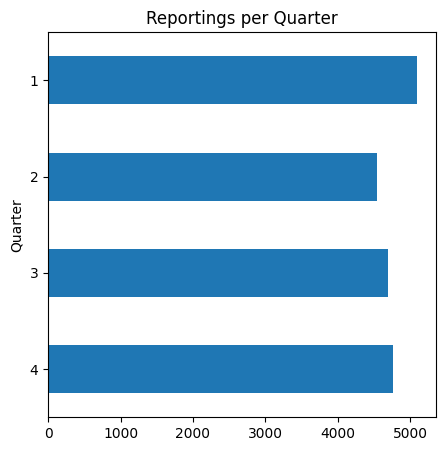

In [ ]:
plt.figure(figsize=(5,5))
df['Reporting_month'].dt.quarter.value_counts().sort_index().plot(kind='barh')
plt.title('Reportings per Quarter')
plt.ylabel('Quarter')
plt.gca().invert_yaxis()
plt.show()

**Insights:**

- The reporting per month is highest in January 2019 while it has been decreasing heavily post that.
- Though it has been stable in last months of 2020 it can be due to new joinings too.
- If we compare the yearly reportings, it is more in 2019 than 2020.
- For comparing months reportings are high in january and December but lowest in June month.
- Quarter 1 and 4 have high reportings than Q3 and Q4.

In [ ]:
# @title Driver Count
driver_total=df.Driver_ID.nunique()
driver_left=df.groupby('Driver_ID')['LastWorkingDate'].count().sum()

print("Total drivers :",driver_total,"\nRemain drivers :",driver_left)

Total drivers : 2381 
Remain drivers : 1616


In [ ]:
# @title Last Working Date
get_column_details(df,column='LastWorkingDate',title='Last days')

Details of  LastWorkingDate  column
**************************************************

DataType:  datetime64[ns]
**************************************************

Unique values are:  493
**************************************************

Count of Drivers Last days wise:

LastWorkingDate
2020-07-29    70
2019-09-22    26
2019-03-17    14
2020-11-28    13
2020-02-17    13
              ..
2019-11-12     1
2019-08-11     1
2019-06-18     1
2019-04-15     1
2020-10-28     1
Name: count, Length: 493, dtype: int64
**************************************************

Percentage of Drivers Last days wise:

LastWorkingDate
2020-07-29    4.33
2019-09-22    1.61
2019-03-17    0.87
2020-11-28    0.80
2020-02-17    0.80
              ... 
2019-11-12    0.06
2019-08-11    0.06
2019-06-18    0.06
2019-04-15    0.06
2020-10-28    0.06
Name: proportion, Length: 493, dtype: float64
**************************************************


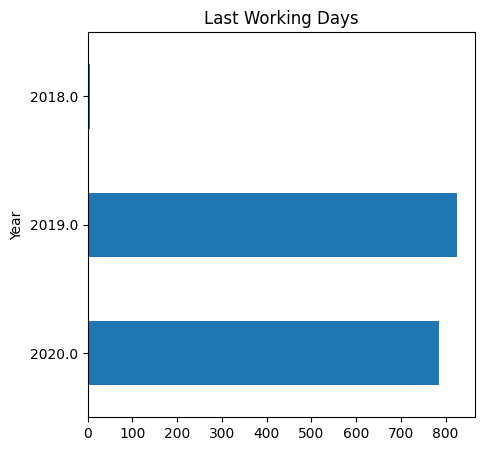

In [ ]:
plt.figure(figsize=(5,5))
df['LastWorkingDate'].dt.year.value_counts().sort_index().plot(kind='barh')
plt.title('Last Working Days')
plt.ylabel('Year')
plt.gca().invert_yaxis()
plt.show()

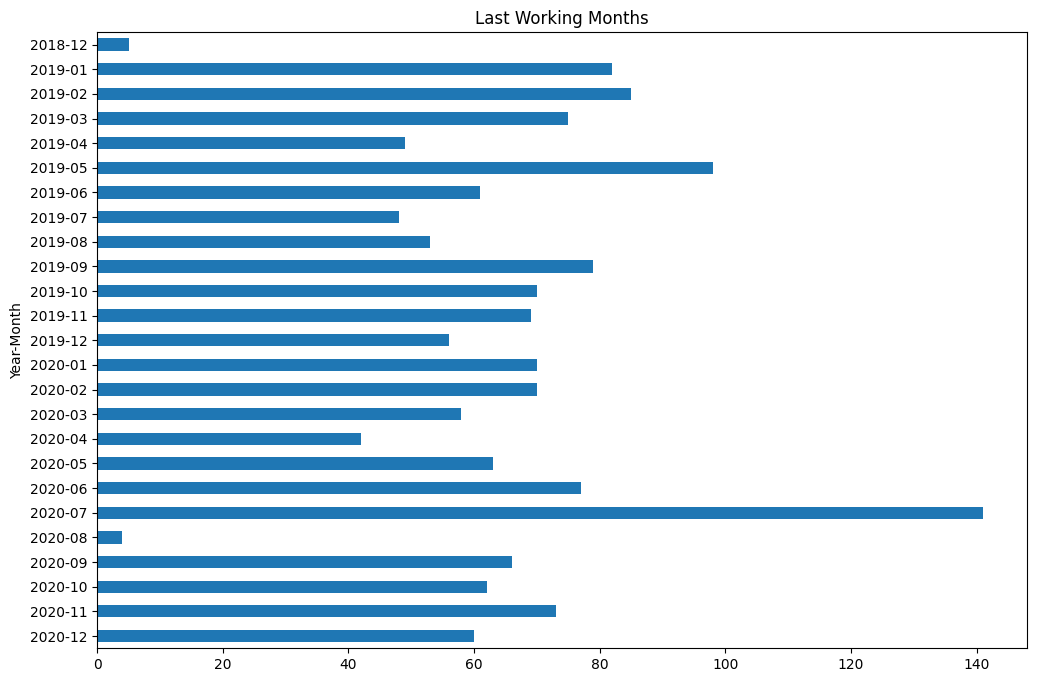

In [ ]:
df['LastWorkingDate'].dt.strftime('%Y-%m').value_counts().sort_index().plot(kind='barh')
plt.title('Last Working Months')
plt.ylabel('Year-Month')
plt.gca().invert_yaxis()
plt.show()

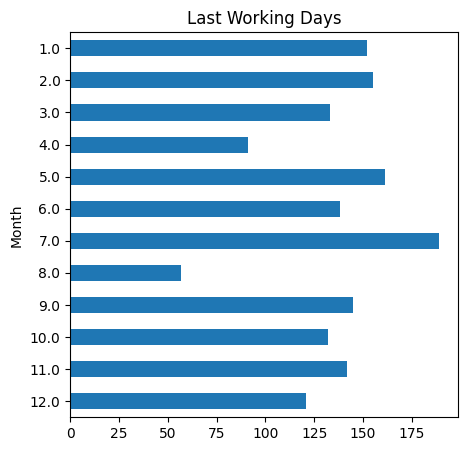

In [ ]:
plt.figure(figsize=(5,5))
df['LastWorkingDate'].dt.month.value_counts().sort_index().plot(kind='barh')
plt.title('Last Working Days')
plt.ylabel('Month')
plt.gca().invert_yaxis()
plt.show()

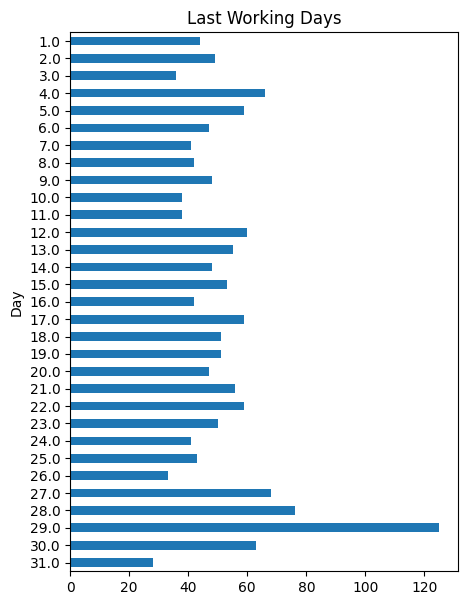

In [ ]:
plt.figure(figsize=(5,7))
df['LastWorkingDate'].dt.day.value_counts().sort_index().plot(kind='barh')
plt.title('Last Working Days')
plt.ylabel('Day')
plt.gca().invert_yaxis()
plt.show()

**Insights:**

- Total 2381 drivers data is given, out of which 1616, i.e. almost **68%** left the company.
- More drivers churned in 2019 as compared to 2020 but the difference is minimal.
- Most drivers churned in July and May while least in August and April.
- Most drivers churned in last days of the month.
- Churning was least in August 2020 while highest in July 2020.

In [ ]:
# @title City with highest improvement in Quarterly Ratings

df['year']=df['Reporting_month'].dt.year
dff=df.groupby(['Driver_ID','year'])['Ratings_increased'].sum().reset_index().pivot_table(columns='year',values='Ratings_increased',index='Driver_ID',aggfunc='sum')
dff.fillna(0,inplace=True)
df_merge=dff.merge(df[['Driver_ID','City']].drop_duplicates(),on='Driver_ID',how='left')
df_merge['rating_diff_year']=df_merge[2020]-df_merge[2019]
df_merge.head()

,Driver_ID,2019,2020,City,rating_diff_year
0,1,0.0,0.0,C23,0.0
1,2,0.0,0.0,C7,0.0
2,4,0.0,0.0,C13,0.0
3,5,0.0,0.0,C9,0.0
4,6,0.0,1.0,C11,1.0


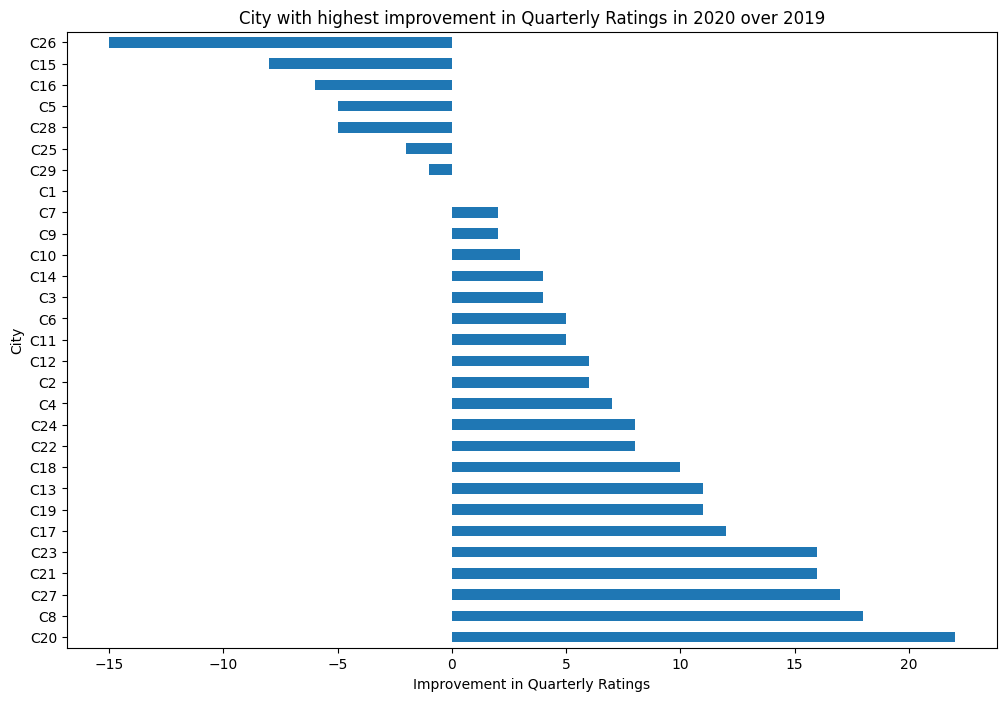

In [ ]:
df_merge.groupby('City')['rating_diff_year'].sum().sort_values(ascending=False).plot(kind='barh')
plt.title('City with highest improvement in Quarterly Ratings in 2020 over 2019')
plt.xlabel('Improvement in Quarterly Ratings')
plt.show()

**Insights:**

C26 has most decline in quarterly ratings followed by C15 and C16 in 2020 compared to 2019 while C20 has seen most increase in ratings followed by C8 and C27.

In [ ]:
df.columns

Index(['Reporting_month', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating', 'next_rating', 'next_Income', 'Ratings_increased',
       'Income_increased', 'Churn', 'year'],
      dtype='object')

In [ ]:
df['significant_drop'] = df['Ratings_increased'] <= -1  # Assuming a drop of -1 or more is significant

# Get the next period's business value for each driver
df['next_total_business_value'] = df.groupby('Driver_ID')['Total Business Value'].shift(-1)

# Replace NaNs with 0 (if that's appropriate in your case)
df['next_total_business_value'].fillna(0, inplace=True)

# Filter rows with significant drops and compute mean impact per driver
mean_impact_per_driver = (
    df[df['significant_drop']]
    .groupby('Driver_ID')['next_total_business_value']
    .mean()
)
mean_impact_per_driver

,next_total_business_value
Driver_ID,
12,0.000000e+00
13,0.000000e+00
17,2.426500e+05
21,7.508500e+04
22,2.335033e+05
...,...
2781,1.098640e+06
2784,1.004500e+05
2786,3.184600e+05


## **Data Aggregation**

In [ ]:
aggfunction={'Reporting_month':'last',
             'Age':'max',
             'Gender':'last',
             'City':'last',
             'Education_Level':'max',
            'Income':'max',
            'Dateofjoining':'last',
            'LastWorkingDate':'last',
            'Joining Designation':'last',
             'Grade':'last',
             'Total Business Value':'sum',
              'Quarterly Rating':'last',
             'Ratings_increased':'sum',
             'Income_increased':'sum',
             'Churn':'last'}

In [ ]:
df_agg=df.groupby('Driver_ID').agg(aggfunction).reset_index()
df_agg.rename(columns={'Reporting_month':'Last_Reporting_month',
                       'Quarterly Rating':'Last_Quarter_Ratings'},inplace=True)
df_agg.head()

,Driver_ID,Last_Reporting_month,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Last_Quarter_Ratings,Ratings_increased,Income_increased,Churn
0,1,2019-03-01,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2,0,0,1
1,2,2020-12-01,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1,0,0,1
3,5,2019-03-01,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1,0,0,1
4,6,2020-12-01,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,2,1,0,0


##**Univariate Analysis**

In [ ]:
# @title Churn Analysis
df_agg['Churn'].value_counts()

,count
Churn,
1,1616
0,765


In [ ]:
# Drivers with negative business value
driver_neg=df[df['Total Business Value']<0]['Driver_ID']
driver_neg.nunique()

136

In [ ]:
df_neg_val_churn=df_agg[df_agg['Churn']==1]['Driver_ID'].isin(driver_neg).value_counts().reset_index()
df_neg_val_churn.rename(columns={'Driver_ID':"Churn_with_Negative_value"}, inplace=True)
df_neg_val_churn

,Churn_with_Negative_value,count
0,False,1515
1,True,101


In [ ]:
# Drivers with zero business value
driver_zero=df_agg[df_agg['Total Business Value']==0]['Driver_ID']
driver_zero.nunique()

719

In [ ]:
df_zero_val_churn=df_agg[df_agg['Churn']==1]['Driver_ID'].isin(driver_zero).value_counts().reset_index()
df_zero_val_churn.rename(columns={'Driver_ID':"Churn_with_Zero_value"}, inplace=True)
df_zero_val_churn

,Churn_with_Zero_value,count
0,False,1064
1,True,552


**Insights:**

- 1616 drivers churned while 765 dont.
- Total business value is negative for 136 drivers and 101 among those left the company.
- It is 0 for 719 drivers and 552 among those left the company. This can be an important feature to find churning drivers

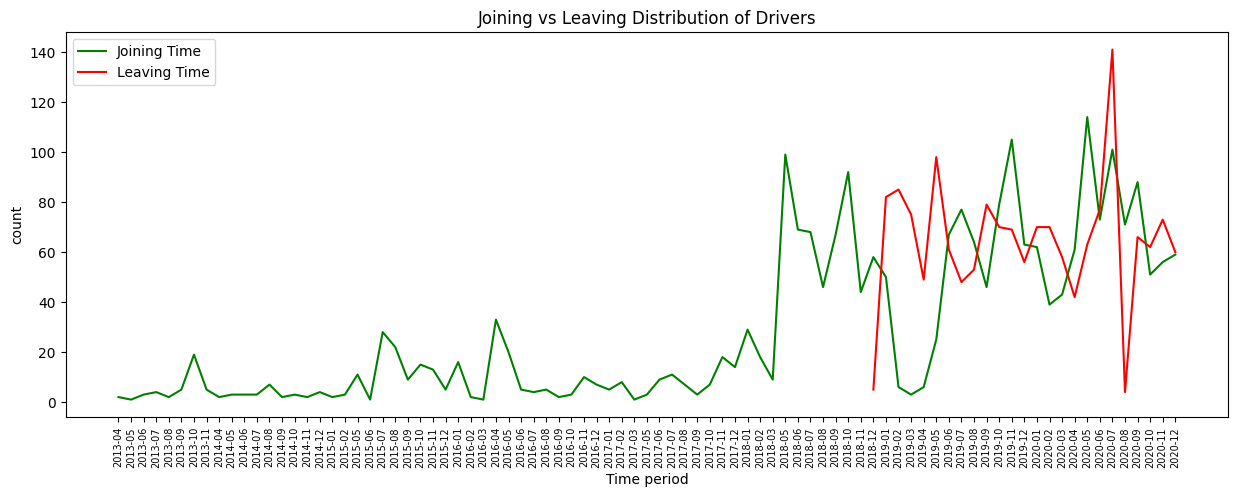

In [ ]:
# @title Comparing Joining Vs leaving
plt.figure(figsize=(15,5))
sns.lineplot(df_agg['Dateofjoining'].dt.strftime('%Y-%m').value_counts().sort_index(),color='green',label='Joining Time')
sns.lineplot(df_agg['LastWorkingDate'].dt.strftime('%Y-%m').value_counts().sort_index(),color='red',label='Leaving Time')
plt.title('Joining vs Leaving Distribution of Drivers')
plt.xticks(rotation=90,size=7)
plt.xlabel('Time period')
plt.legend()
plt.show()

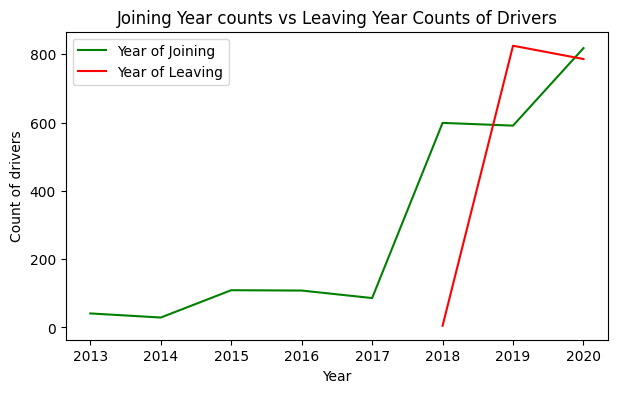

In [ ]:
plt.figure(figsize=(7,4))
sns.lineplot(df_agg['Dateofjoining'].dt.year.value_counts(),color='green',label='Year of Joining')
sns.lineplot(df_agg['LastWorkingDate'].dt.year.value_counts(),color='red',label='Year of Leaving')
plt.title('Joining Year counts vs Leaving Year Counts of Drivers')
plt.xlabel('Year')
plt.ylabel('Count of drivers')
plt.legend()
plt.show()

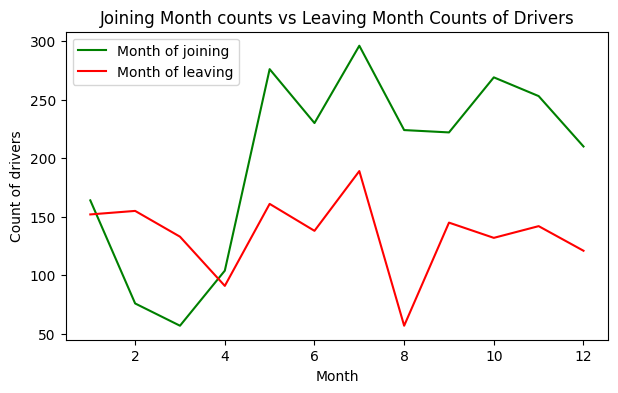

In [ ]:
plt.figure(figsize=(7,4))
sns.lineplot(df_agg['Dateofjoining'].dt.month.value_counts(), color='green', label='Month of joining')
sns.lineplot(df_agg['LastWorkingDate'].dt.month.value_counts(), color='red', label='Month of leaving')
plt.title('Joining Month counts vs Leaving Month Counts of Drivers')
plt.xlabel('Month')
plt.ylabel('Count of drivers')
plt.legend()
plt.show()

**Insights:**

- The data is given from 2013 till 2020 for joining drivers, who are still worling but for only those who left the company in 2019 and 2013.
- Joining period is high in March, October 2018,last months of 2019 and in mid 2020.
- These may be thereason of high churning in start of 2019, extreme in mid 2020.
- Cant comment on attrition before 2018 because no data id given but as joining increased drastically after 2017 alongwith churning which is at peak in 2019, it bells alarms.
- Joining and churning moving together, if we look at month curves, which shows company is trying to keep its work regular though it wont work unless the driver will start staying.

In [ ]:
df_agg.head()

,Driver_ID,Last_Reporting_month,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Last_Quarter_Ratings,Ratings_increased,Income_increased,Churn
0,1,2019-03-01,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2,0,0,1
1,2,2020-12-01,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1,0,0,1
3,5,2019-03-01,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1,0,0,1
4,6,2020-12-01,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,2,1,0,0


Text(0.5, 1.0, 'Distribution of Working Months')

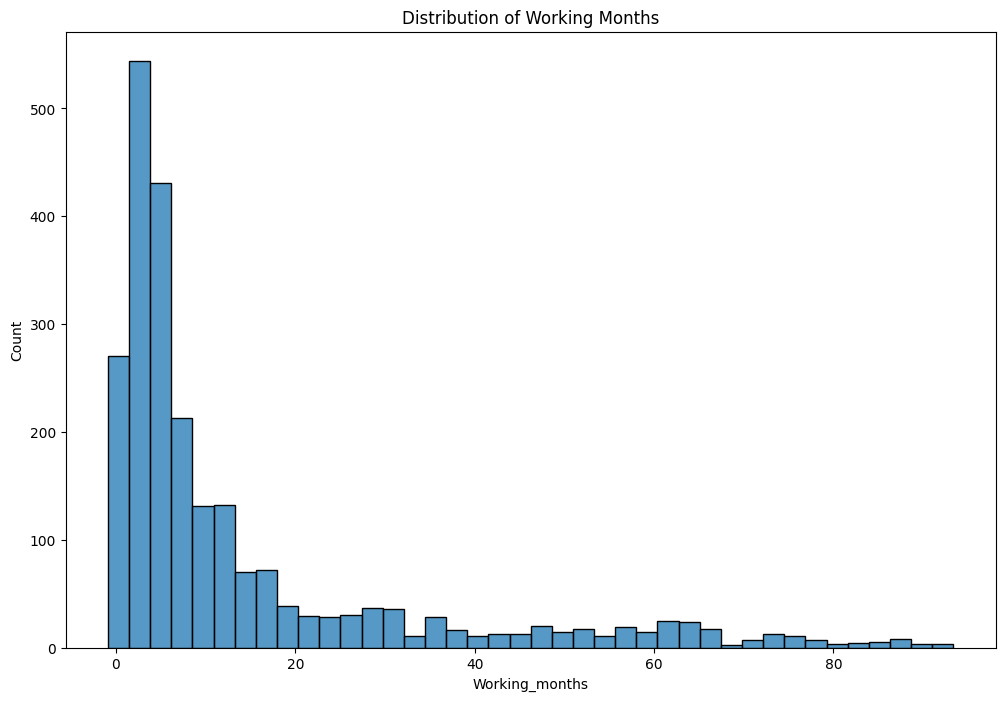

In [ ]:
# @title Feature Engineering

# Finding the tenure of drivers
df_agg['Working_months']=df_agg['Last_Reporting_month']-df_agg['Dateofjoining']
df_agg['Working_months']=(df_agg['Working_months'].dt.days/30).round(2)
sns.histplot(df_agg['Working_months'], bins=40)
plt.title('Distribution of Working Months')

In [ ]:
# @title Gender Analysis

get_column_details(df_agg,'Gender',title='Gender')

Details of  Gender  column
**************************************************

DataType:  category
**************************************************

Unique values are:  2
**************************************************

Count of Drivers Gender wise:

Gender
0.0    1404
1.0     977
Name: count, dtype: int64
**************************************************

Percentage of Drivers Gender wise:

Gender
0.0    58.97
1.0    41.03
Name: proportion, dtype: float64
**************************************************


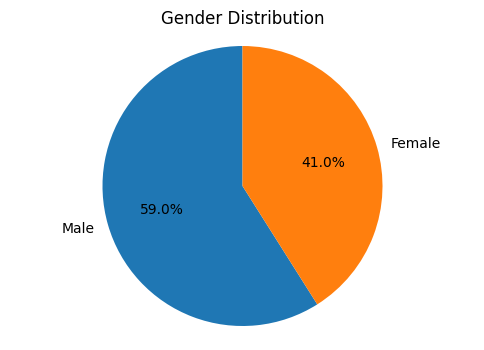

In [ ]:
plt.figure(figsize=(6, 4))

gender_counts = df_agg['Gender'].value_counts()

label_map = {0: 'Male', 1: 'Female'}
text_labels = gender_counts.index.map(label_map)

plt.pie(gender_counts.values, labels=text_labels, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

In [ ]:
# To be deleted

def get_column_details_churn(df, column):
    print(f"Details of '{column}' column")
    print('*' * 50)

    # DataType
    print("\nDataType:", df[column].dtype)
    print('*' * 50)

    # Unique values
    print("\nUnique values:", df[column].nunique())
    print('*' * 50)

    # Counts
    print(f"\nCount of Drivers {column} wise:\n")
    print(df[column].value_counts())
    print('*' * 50)

    # Percentages
    print(f"\nPercentage of Drivers {column} wise:\n")
    print(round(df[column].value_counts(normalize=True) * 100, 2))
    print('*' * 50)


    #Plot distribution with respect to Drivers
    plt.figure(figsize=(6,4))
    sns.barplot(x=df[column].value_counts(), y=df[column].value_counts().index)
    plt.title(f'Driver count vs {column}')
    plt.tight_layout()
    plt.show()


    # Churn breakdown
    print(f"\nChurn with respect to {column} wise:\n")
    title_vs_churn = df.groupby([column, 'Churn']).size().reset_index(name='count')
    print(title_vs_churn)
    print('*' * 50)

    # Plot churn distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=title_vs_churn,
        y=column,
        x='count',
        hue='Churn',
    )

    plt.title(f'Churn Distribution by {column}')
    plt.tight_layout()
    plt.show()

In [ ]:
# @title City Analysis
get_column_details(df_agg,'City',title='City')

Details of  City  column
**************************************************

DataType:  category
**************************************************

Unique values are:  29
**************************************************

Count of Drivers City wise:

City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C1      80
C5      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C23     74
C25     74
C24     73
C19     72
C2      72
C13     71
C17     71
C18     69
C11     64
Name: count, dtype: int64
**************************************************

Percentage of Drivers City wise:

City
C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
C28    3.44
C12    3.40
C1     3.36
C5     3.36
C21    3.32
C14    3.32
C6     3.28
C4     3.23
C7     3.19
C9     3.15
C23    3.11
C25    3.11
C24    3.07
C19    3.02
C2     3.02
C13   

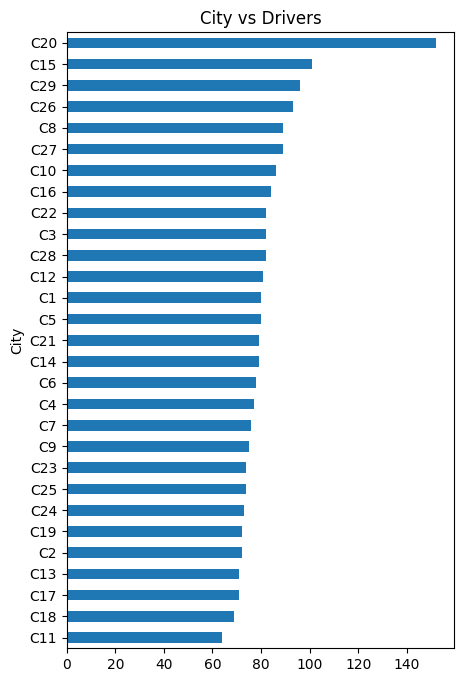

In [ ]:
plt.figure(figsize=(5,8))
df_agg['City'].value_counts().plot(kind='barh')
plt.title('City vs Drivers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Education Level Analysis
get_column_details(df_agg,'Education_Level',title='Education Level')

Details of  Education_Level  column
**************************************************

DataType:  category
**************************************************

Unique values are:  3
**************************************************

Count of Drivers Education Level wise:

Education_Level
2    802
1    795
0    784
Name: count, dtype: int64
**************************************************

Percentage of Drivers Education Level wise:

Education_Level
2    33.68
1    33.39
0    32.93
Name: proportion, dtype: float64
**************************************************


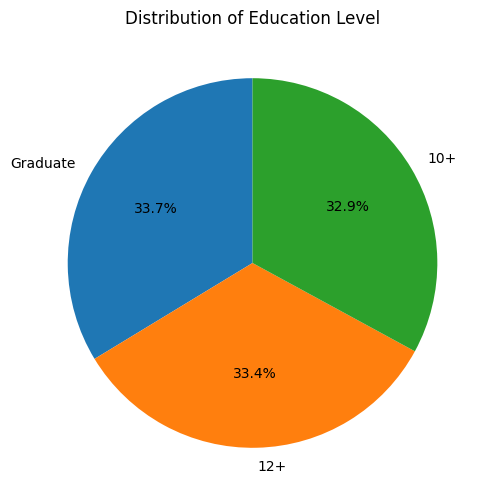

In [ ]:
label_map = {0: '10+',
             1: '12+',
             2: 'Graduate'}

plt.figure(figsize=(6,6))
plt.pie(df_agg['Education_Level'].value_counts(), labels=df_agg['Education_Level'].value_counts().index.map(label_map), autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Education Level')
plt.show()

In [ ]:
# @title Joining Designation Analysis
get_column_details(df_agg,'Joining Designation',title='Joining Designation')

Details of  Joining Designation  column
**************************************************

DataType:  category
**************************************************

Unique values are:  5
**************************************************

Count of Drivers Joining Designation wise:

Joining Designation
1    1026
2     815
3     493
4      36
5      11
Name: count, dtype: int64
**************************************************

Percentage of Drivers Joining Designation wise:

Joining Designation
1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: proportion, dtype: float64
**************************************************


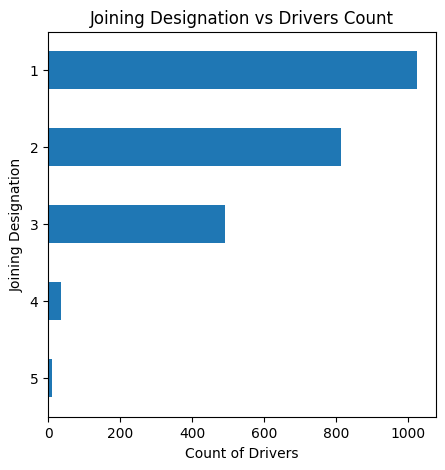

In [ ]:
plt.figure(figsize=(5,5))
df_agg['Joining Designation'].value_counts().plot(kind='barh')
plt.title('Joining Designation vs Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Grade Analysis
get_column_details(df_agg,'Grade',title='Grade')

Details of  Grade  column
**************************************************

DataType:  category
**************************************************

Unique values are:  5
**************************************************

Count of Drivers Grade wise:

Grade
2    855
1    741
3    623
4    138
5     24
Name: count, dtype: int64
**************************************************

Percentage of Drivers Grade wise:

Grade
2    35.91
1    31.12
3    26.17
4     5.80
5     1.01
Name: proportion, dtype: float64
**************************************************


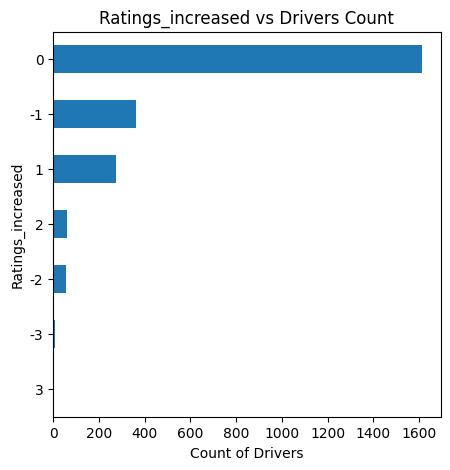

In [ ]:
# Graphical analysis

plt.figure(figsize=(5,5))
df_agg['Ratings_increased'].value_counts().plot(kind='barh')
plt.title('Ratings_increased vs Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

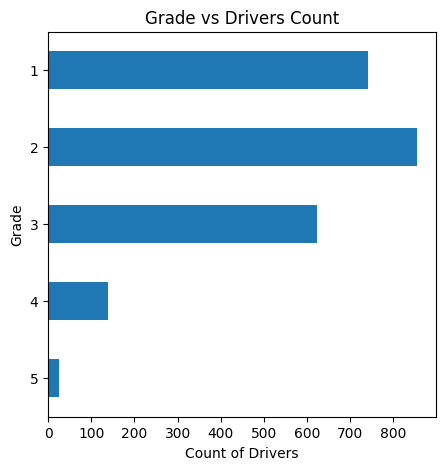

In [ ]:
plt.figure(figsize=(5,5))
df_agg['Grade'].value_counts().sort_index().plot(kind='barh')
plt.title('Grade vs Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Quarterly Rating Analysis
get_column_details(df_agg,'Last_Quarter_Ratings',title='Quarterly Ratings')

Details of  Last_Quarter_Ratings  column
**************************************************

DataType:  int64
**************************************************

Unique values are:  4
**************************************************

Count of Drivers Quarterly Ratings wise:

Last_Quarter_Ratings
1    1744
2     362
3     168
4     107
Name: count, dtype: int64
**************************************************

Percentage of Drivers Quarterly Ratings wise:

Last_Quarter_Ratings
1    73.25
2    15.20
3     7.06
4     4.49
Name: proportion, dtype: float64
**************************************************


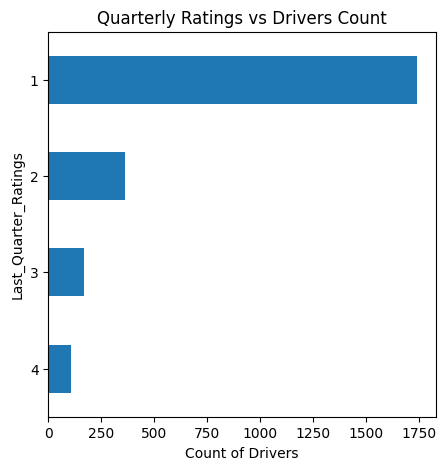

In [ ]:
plt.figure(figsize=(5,5))
df_agg['Last_Quarter_Ratings'].value_counts().sort_index().plot(kind='barh')
plt.title('Quarterly Ratings vs Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Ratings Change Analysis
get_column_details(df_agg,'Ratings_increased',title='Ratings increased')

Details of  Ratings_increased  column
**************************************************

DataType:  int64
**************************************************

Unique values are:  7
**************************************************

Count of Drivers Ratings increased wise:

Ratings_increased
 0    1614
-1     361
 1     274
 2      60
-2      58
-3      10
 3       4
Name: count, dtype: int64
**************************************************

Percentage of Drivers Ratings increased wise:

Ratings_increased
 0    67.79
-1    15.16
 1    11.51
 2     2.52
-2     2.44
-3     0.42
 3     0.17
Name: proportion, dtype: float64
**************************************************


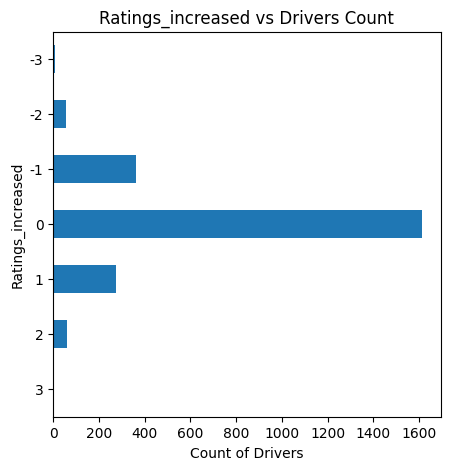

In [ ]:
plt.figure(figsize=(5,5))
df_agg['Ratings_increased'].value_counts().sort_index().plot(kind='barh')
plt.title('Ratings_increased vs Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Income Change Analysis
get_column_details(df_agg,'Income_increased',title='Income increased')

Details of  Income_increased  column
**************************************************

DataType:  int64
**************************************************

Unique values are:  2
**************************************************

Count of Drivers Income increased wise:

Income_increased
0    2338
1      43
Name: count, dtype: int64
**************************************************

Percentage of Drivers Income increased wise:

Income_increased
0    98.19
1     1.81
Name: proportion, dtype: float64
**************************************************


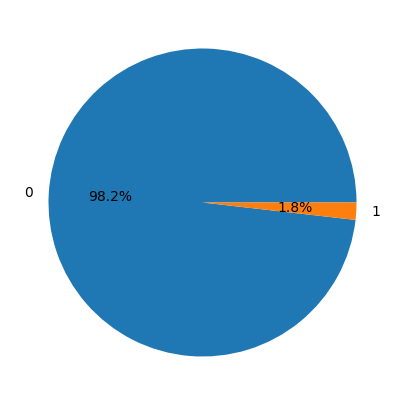

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(df_agg['Income_increased'].value_counts(),labels=df_agg['Income_increased'].value_counts().index,autopct='%1.1f%%')

plt.show()

**Insights:**

- The high number of employees are having very less tenure below 1 year, and those staying for long are very low, which is alarming.
- Out of 2381 employees, 1404 employees are males and 977 are females.
-  Out of total employees, 152 employees are from city C20 and 101 from city C15 and the least from cities 11,18 and 13.
- Out of total employees, 802 employees have completed their graduation and 795 have completed their 12th while 784 completed 10th standard.
- Out of total employees, 1026 joined on designation 1, 815 employees joined on designation 2 and as grade increases the number reduces, which makes sense too as higher grade employees used to be less in organisations.
- Out of total employees, 855 employees had their grade as 2 at the time of reporting, 741 as 2 while only 24 as grade 5.
- Out of total employees, 1744 employees had their last quarterly rating as 1, while the number is decreasing as moving towards higher ratings.It decreased drastically to 362 for ratimg 1 and 168 and 107 to ratings 3 and 4, no driver is at rating 5.
- Out of total employees, the quarterly rating has not increased for 1614(68% employees.It reduced for 429 employees, infact for 58 employees, 2 times and for 10 even 3 times ratings has been reduced.
- Though their are good employees(274) too whose ratings has been increase once, for 60 - twice and only for 4 it is increased to 3 times even.
- Out of total employees, for 2338 (98%) employees there is no change in income, which can be a potential sign of churning as those who are working from last 2-3 years may be expecting some income hikes which is there for 43 employees only, so they left the company if get better salary.

In [ ]:
# Converting the datatype of discrete categorical values
df_agg['Last_Quarter_Ratings']=df_agg['Last_Quarter_Ratings'].astype('category')

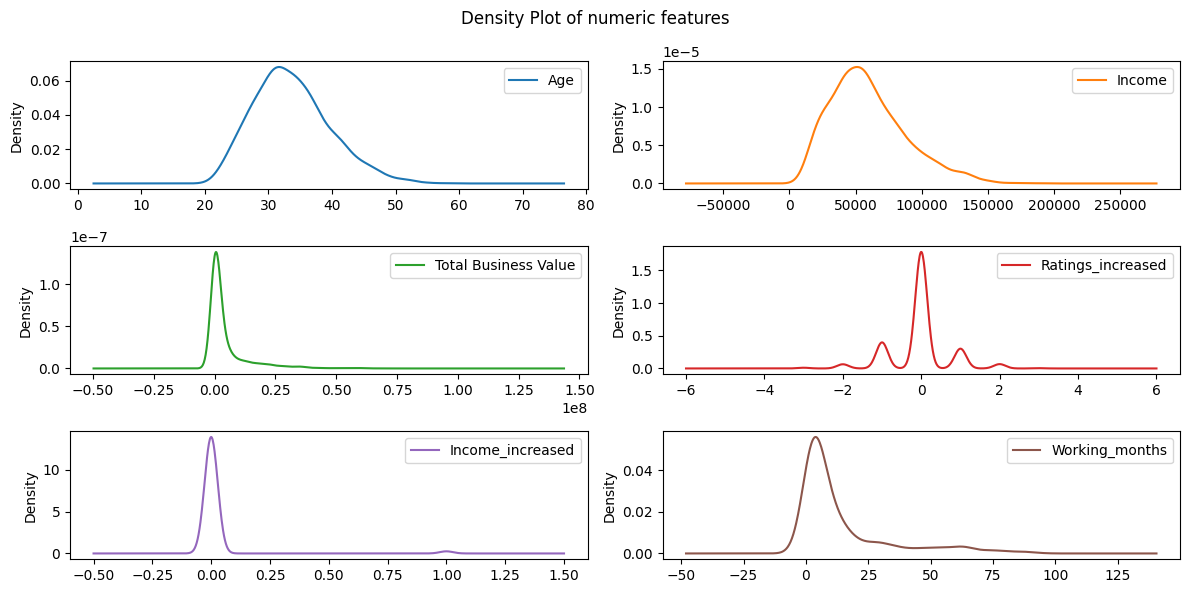

In [ ]:
# @title Numerical Features Analysis

num_col=df_agg.select_dtypes(np.number).columns
num_col=num_col.drop(['Driver_ID','Churn'])

plt.rcParams['figure.figsize']=(12,6)
df_agg[num_col].plot(kind='kde', subplots=True, layout=(3,2), sharex=False)
plt.suptitle('Density Plot of numeric features')
plt.tight_layout()
plt.show()

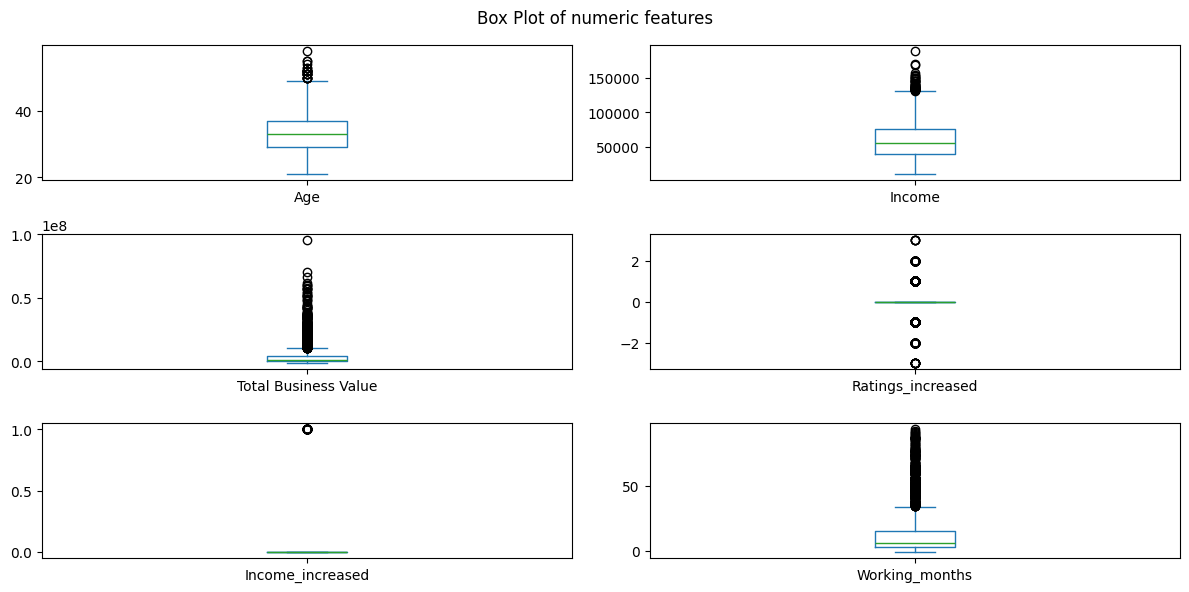

In [ ]:
# @title Detecting Outliers
plt.rcParams['figure.figsize'] = (12, 6)
# Plotting the boxplot with filled boxes
df_agg[num_col].plot(kind='box', subplots=True, layout=(3, 2), sharex=False)
plt.suptitle('Box Plot of numeric features')
plt.tight_layout()
plt.show()

In [ ]:
# @title Outlier Treatment
df_agg['Age']=np.clip(df_agg['Age'],20,np.percentile(df_agg['Age'],95))
df_agg['Income']=np.clip(df_agg['Income'],0,np.percentile(df_agg['Income'],95))
df_agg['Total Business Value']=np.clip(df_agg['Total Business Value'],df_agg['Total Business Value'].min(),np.percentile(df_agg['Total Business Value'],95))
df_agg['Working_months']=np.clip(df_agg['Working_months'],0,np.percentile(df_agg['Working_months'],95))

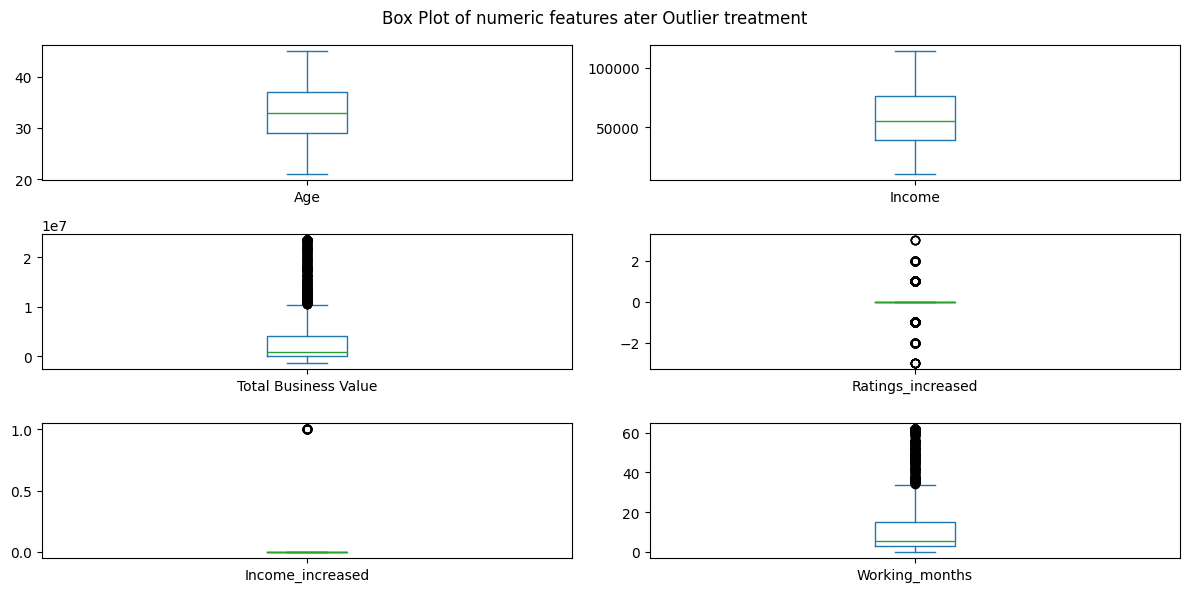

In [ ]:
# @title Detecting Outliers
plt.rcParams['figure.figsize'] = (12, 6)
# Plotting the boxplot with filled boxes
df_agg[num_col].plot(kind='box', subplots=True, layout=(3, 2), sharex=False)
plt.suptitle('Box Plot of numeric features ater Outlier treatment')
plt.tight_layout()
plt.show()

**Insights:**

- The distribution of age slightly skewed on right which might indicate the outliers in the data(high age people) while average age of employees is approx **33** which shows mostly employees are young.
- The distribution of monthly income skewed on right which might indicate the outliers in the data i.e. employees who are earning quite high than other employees.
- The distribution of total business value highly skewed on right which might indicate the outliers in the data and shows there are many drivers who are earning more ,should give them some incentives or awards for their performance,
though it can be due to more number of working months too so need to dive deep into the reason for that.
- The working months also skewed towards right which indicates very less employees are working for long time and very high for less number of months.
- It was observed that the outliers still persist at 95% values. Hence, not removing the outliers as they might be significant

## **Statistical Summary of Aggregated data**

In [ ]:
df_agg.describe().T

,count,mean,min,25%,50%,75%,max,std
Driver_ID,2381.0,1397.559009,1.0,695.0,1400.0,2100.0,2788.0,806.161628
Last_Reporting_month,2381,2020-03-31 15:04:09.475010560,2019-01-01 00:00:00,2019-09-01 00:00:00,2020-06-01 00:00:00,2020-12-01 00:00:00,2020-12-01 00:00:00,NaN
Age,2381.0,33.527089,21.0,29.0,33.0,37.0,45.0,5.654904
Income,2381.0,58539.032759,10747.0,39104.0,55315.0,75986.0,113807.0,26404.699529
Dateofjoining,2381,2019-02-08 07:14:50.550189056,2013-04-01 00:00:00,2018-06-29 00:00:00,2019-07-21 00:00:00,2020-05-02 00:00:00,2020-12-28 00:00:00,NaN
LastWorkingDate,1616,2019-12-21 20:59:06.534653440,2018-12-31 00:00:00,2019-06-06 00:00:00,2019-12-20 12:00:00,2020-07-03 00:00:00,2020-12-28 00:00:00,NaN
Total Business Value,2381.0,3948889.895002,-1385530.0,0.0,817680.0,4173650.0,23471030.0,6599779.33701
Ratings_increased,2381.0,-0.042419,-3.0,0.0,0.0,0.0,3.0,0.718517
Income_increased,2381.0,0.01806,0.0,0.0,0.0,0.0,1.0,0.133195
Churn,2381.0,0.678706,0.0,0.0,1.0,1.0,1.0,0.467071


In [ ]:
df_agg.describe(include=['object','category']).T

,count,unique,top,freq
Gender,2381.0,2.0,0.0,1404.0
City,2381,29,C20,152
Education_Level,2381,3,2,802
Joining Designation,2381,5,1,1026
Grade,2381,5,2,855
Last_Quarter_Ratings,2381,4,1,1744


- **Driver Age**: The average age of drivers is 33.5 years, with most drivers falling between 29 and 37 years old. The youngest driver is 21, and the oldest is 45 after ouliers removal.
- **Income**: The average monthly income is around 58.5K, with significant variation. The lowest income is 10.7K, while the highest reaches 113.8K and that too after outliers removal.
- **Business Value**: Drivers generate an average total business value of around 3.95M, but this varies greatly, with some drivers even having negative values (losses).
- **Churn Rate**: Approximately 68% of drivers have churned, indicating a high attrition rate in the company.
- **Working Tenure**: On average, drivers work for 13.4 months, with a range from 0 to 61 months.
- **Ratings & Income Increase**: Minimal growth in ratings (-0.04 on average) and income (only 1.8% experienced income growth), reflecting stagnation in driver performance and earnings.
- **Gender**: Of the 2,381 drivers, the majority (59%) are male (coded as '0'), with 1,404 drivers.
- **City**: Drivers are spread across 29 cities, with 'C20' being the most common city, having 152 drivers.
- **Education Level**: The majority of drivers (33.7%) have an education level of '2', with 802 drivers.
- **Joining Designation**: Most drivers (43.1%) joined at designation '1', representing 1,026 drivers.
- **Grade**: Grade '2' is the most common, with 855 drivers (35.9%).
- **Quarterly Rating**: The majority (73.2%) of drivers have a quarterly rating of '1', indicating lower performance for many drivers.

## **Bivariate Analysis**

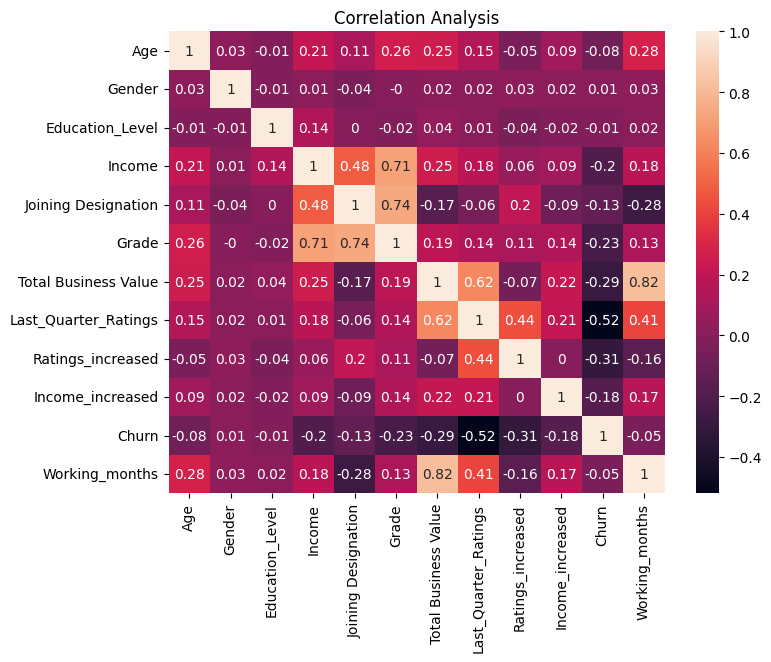

In [ ]:
# @title Correlation Analysis
plt.figure(figsize=(8,6))
req_col=df_agg.select_dtypes(['int64','float64','category']).columns
req_col=req_col.drop(['Driver_ID','City'])
sns.heatmap(df_agg[req_col].corr(method='spearman').round(2),annot=True)
plt.title('Correlation Analysis')
plt.show()

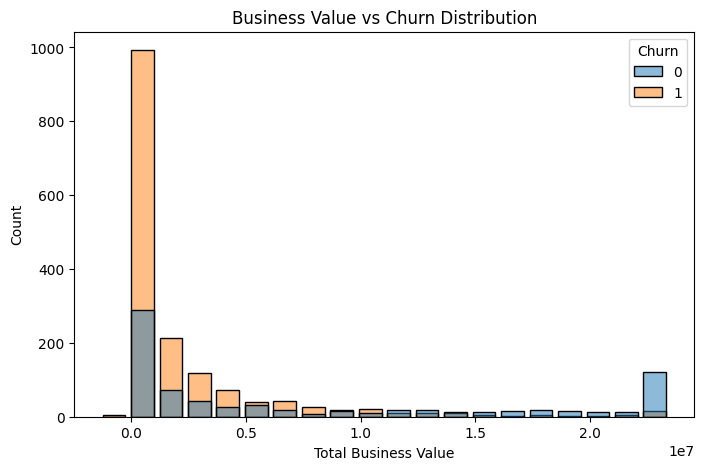

In [ ]:
# @title Total Business Value vs Churn
plt.figure(figsize=(8,5))
sns.histplot( x=df_agg['Total Business Value'], hue=df_agg['Churn'],bins=20, shrink=.8)
plt.title('Business Value vs Churn Distribution')
plt.show()

In [ ]:
churn_business_relation=df_agg.groupby(['Churn'])['Total Business Value'].mean().reset_index()
churn_business_relation

,Churn,Total Business Value
0,0,7.863095e+06
1,1,2.095940e+06


**Insights:**

- Average Total Business Value is 7.86 million for non churn drivers, significantly higher than those who churned(2.10 million).
- Drivers who do not churn have more stable and significantly higher business value, indicating that top performers are less likely to leave while underperforming drivers are more prone to attrition, potentially due to dissatisfaction or misalignment with company incentives.
- There is a wide variability in performance among non-churned drivers, meaning some non-churners excel far beyond the average, contributing immensely to business success.
- Although most churned drivers have lower business value, a few still contribute significantly before leaving, indicating that the company could lose high performers due to churn, which warrants further investigation into retention strategies for these top contributors.
- But this can also be due to more number of drivers leaving and not serving for long time that their business value is less.
- Non-churned drivers tend to generate significantly higher business value, indicating that better-performing drivers are more likely to stay.

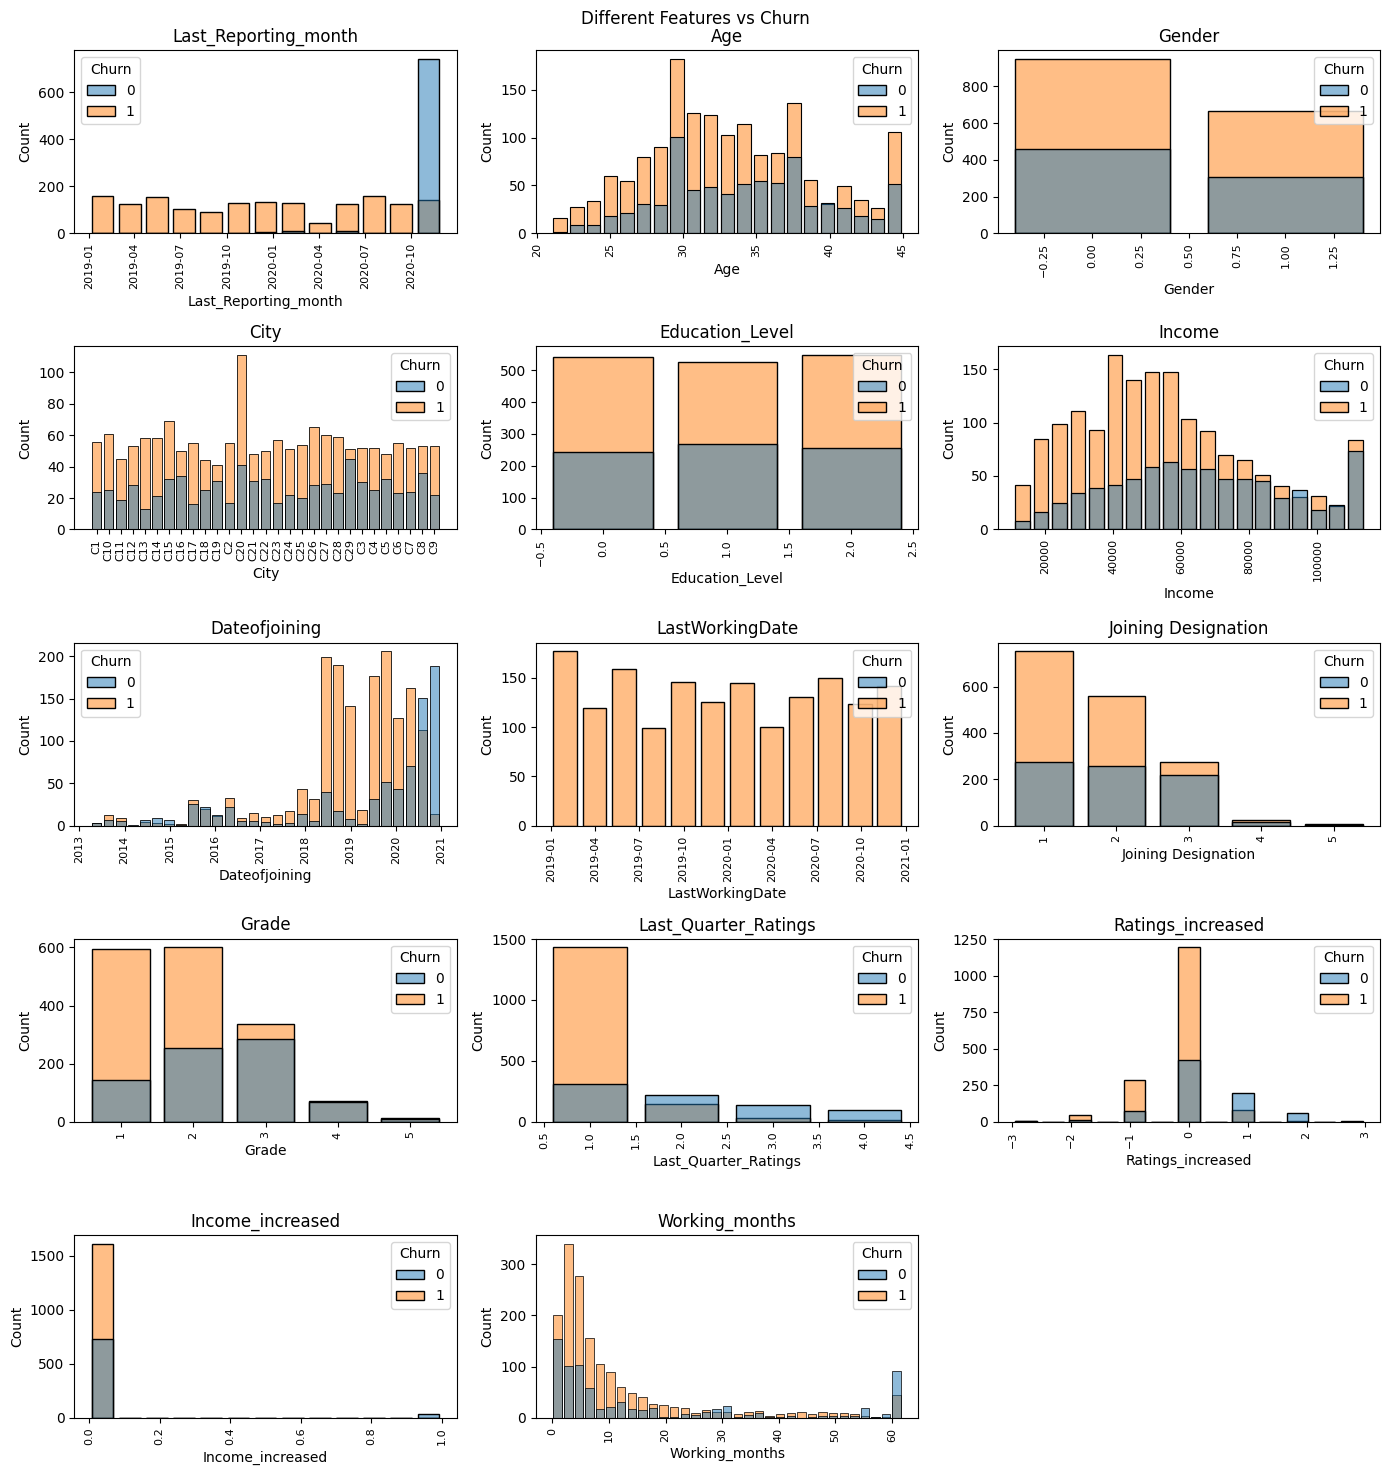

In [ ]:
# @title Different Features vs Churn
columns=df_agg.columns.drop(['Churn','Driver_ID','Total Business Value'])
plt.figure(figsize=(14,15))
plt.suptitle('Different Features vs Churn')
for i,col in enumerate(columns):
  plt.subplot(5,3,i+1)
  sns.histplot(x=df_agg[col],hue=df_agg['Churn'],shrink=.8)
  plt.title(col)
  plt.xticks(rotation=90,size=8)
plt.tight_layout()
plt.show()

In [ ]:
for col in columns:
    churn_relation = df_agg.groupby(['Churn', col]).size().reset_index(name='count').sort_values(by=['Churn','count'],ascending=[True,False])
    print(f"Churn relation for column: {col}\n")
    print(churn_relation, "\n")
    print('*' * 50)

Churn relation for column: Last_Reporting_month

    Churn Last_Reporting_month  count
7       0           2020-12-01    741
3       0           2020-02-01      6
5       0           2020-05-01      6
1       0           2019-12-01      4
2       0           2020-01-01      3
4       0           2020-03-01      2
6       0           2020-06-01      2
0       0           2019-09-01      1
12      1           2019-05-01    101
16      1           2019-09-01     89
26      1           2020-07-01     87
8       1           2019-01-01     84
31      1           2020-12-01     78
9       1           2019-02-01     75
10      1           2019-03-01     75
21      1           2020-02-01     72
27      1           2020-08-01     70
20      1           2020-01-01     67
19      1           2019-12-01     66
18      1           2019-11-01     65
30      1           2020-11-01     64
24      1           2020-05-01     63
17      1           2019-10-01     62
25      1           2020-06-01     62
2

**Insights:**

*   **Reporting Month**:
  - It can be seen that there are some drivers even who didnt report after a tim eperiod but there last working day is not shown, they can be either on leave, or on hold or some data inconsistency.
  - If these drivers are thinking about leaving company should approach them for retaining.
* **Age**
  - Churned drivers tend to be slightly younger on average with high attrition till 38 years age, suggesting that younger drivers may face more challenges or have different expectations.
  - Non-churned drivers show a bit more stability in age as less attrition comparatively after 40, which might correlate with higher retention in more experienced or mature demographics.  
* **Gender, Education Level**
  - In both genders churn rate is quite similar almost 67-68%, showing no impact of gender basically.
  - No impact of education level too on Churning
* **City**
  - Cities like C20 have the highest number of churned drivers (111), suggesting potential issues in driver satisfaction or operational challenges.
  - Cities such as C15 (69 churned drivers) and C26 (65 churned) also indicate high churn, which could signal underlying factors like inadequate support or compensation issues.
  - Conversely, cities like C5,C19 a and C29 have relatively balanced churn rates, implying a need to investigate city-specific influences, such as local demand or working conditions, to better manage attrition. This may indicate favorable working conditions, high demand, or better alignment with driver expectations in these cities.
* **Income**
  - With increase in income churn rate is decreasing which shows attrition can be the sign of less salary or more salary expectations.
* **Joining Time**
  - Employees joining in 2013- 2017 are still loyal as attrition rate is not that high for those drivers but for those who joined from 2018, it is too high.
* **Joining Designation**
  - Foe employees joined on designation 1 the attrition rate is 73% while it decreases to 68% and 55% for 2 and 3 desination.
  - Though it is high again for designation 4 and 5 (36 and 11 respectively) but it may be due to very less drivers at that designation that results are skewed.
* **Grade**  
  - Attrition rate for grade 1 and 2 employees are 80 and 70 % respectively while it is low for grade 3,4 and 5 grade(near to 50%).
* **Last Quarter Ratings**
  - Attrition rate is 82% for 1 rating driver, while it decreased signficantly 40%, 16% and 9% for 2,3 and 4 ratings rivers respectively.
* **Ratings and Income Changed**
  - Drivers whose rating is either decreased or remained same are more likely to churn than those whose ratings improved with time.
  - The drivers whose incomw has been increased stayed in the company with 93% attrition which is a positive sign.
* **Working Month**
  - Retention rate is high where drivers worked in company for near to 5 years else the attrition is high.   

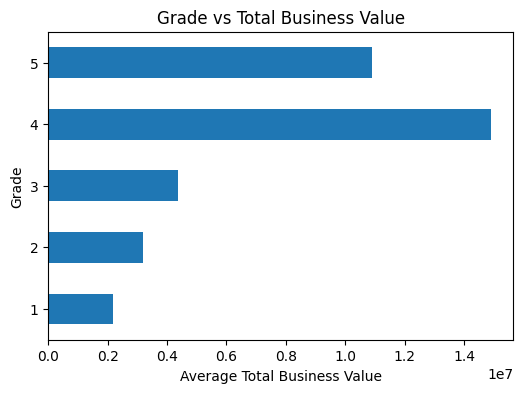

In [ ]:
# @title Grade vs Total Business Value

# Drivers with a Grade of ‘A’ are more likely to have a higher Total Business Value.(T/F)<br>
plt.figure(figsize=(6,4))
df_agg.groupby('Grade')['Total Business Value'].mean().sort_index().plot(kind='barh')
plt.title('Grade vs Total Business Value')
plt.xlabel('Average Total Business Value')
plt.show()

Grade 4 drivers gave the maximum Total Business Value followed by Grade 5 drivers.

## **Multivariate Analysis**

In [ ]:
df_agg

,Driver_ID,Last_Reporting_month,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Last_Quarter_Ratings,Ratings_increased,Income_increased,Churn,Working_months
0,1,2019-03-01,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2,0,0,1,2.23
1,2,2020-12-01,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,0,0.83
2,4,2020-04-01,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1,0,0,1,3.87
3,5,2019-03-01,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1,0,0,1,1.70
4,6,2020-12-01,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1265000,2,1,0,0,4.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0,82815,2015-10-15,NaT,2,3,21748820,4,1,0,0,61.77
2377,2785,2020-10-01,34.0,1.0,C9,0,12105,2020-08-28,2020-10-28,1,1,0,1,0,0,1,1.13
2378,2786,2019-09-01,45.0,0.0,C19,0,35370,2018-07-31,2019-09-22,2,2,2815090,1,-1,0,1,13.23
2379,2787,2019-06-01,28.0,1.0,C20,2,69498,2018-07-21,2019-06-20,1,1,977830,1,-1,0,1,10.50


In [ ]:
columns=df_agg.columns.drop(['Driver_ID','LastWorkingDate'])
columns

Index(['Last_Reporting_month', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'Joining Designation', 'Grade',
       'Total Business Value', 'Last_Quarter_Ratings', 'Ratings_increased',
       'Income_increased', 'Churn', 'Working_months'],
      dtype='object')

<Figure size 1400x1700 with 0 Axes>

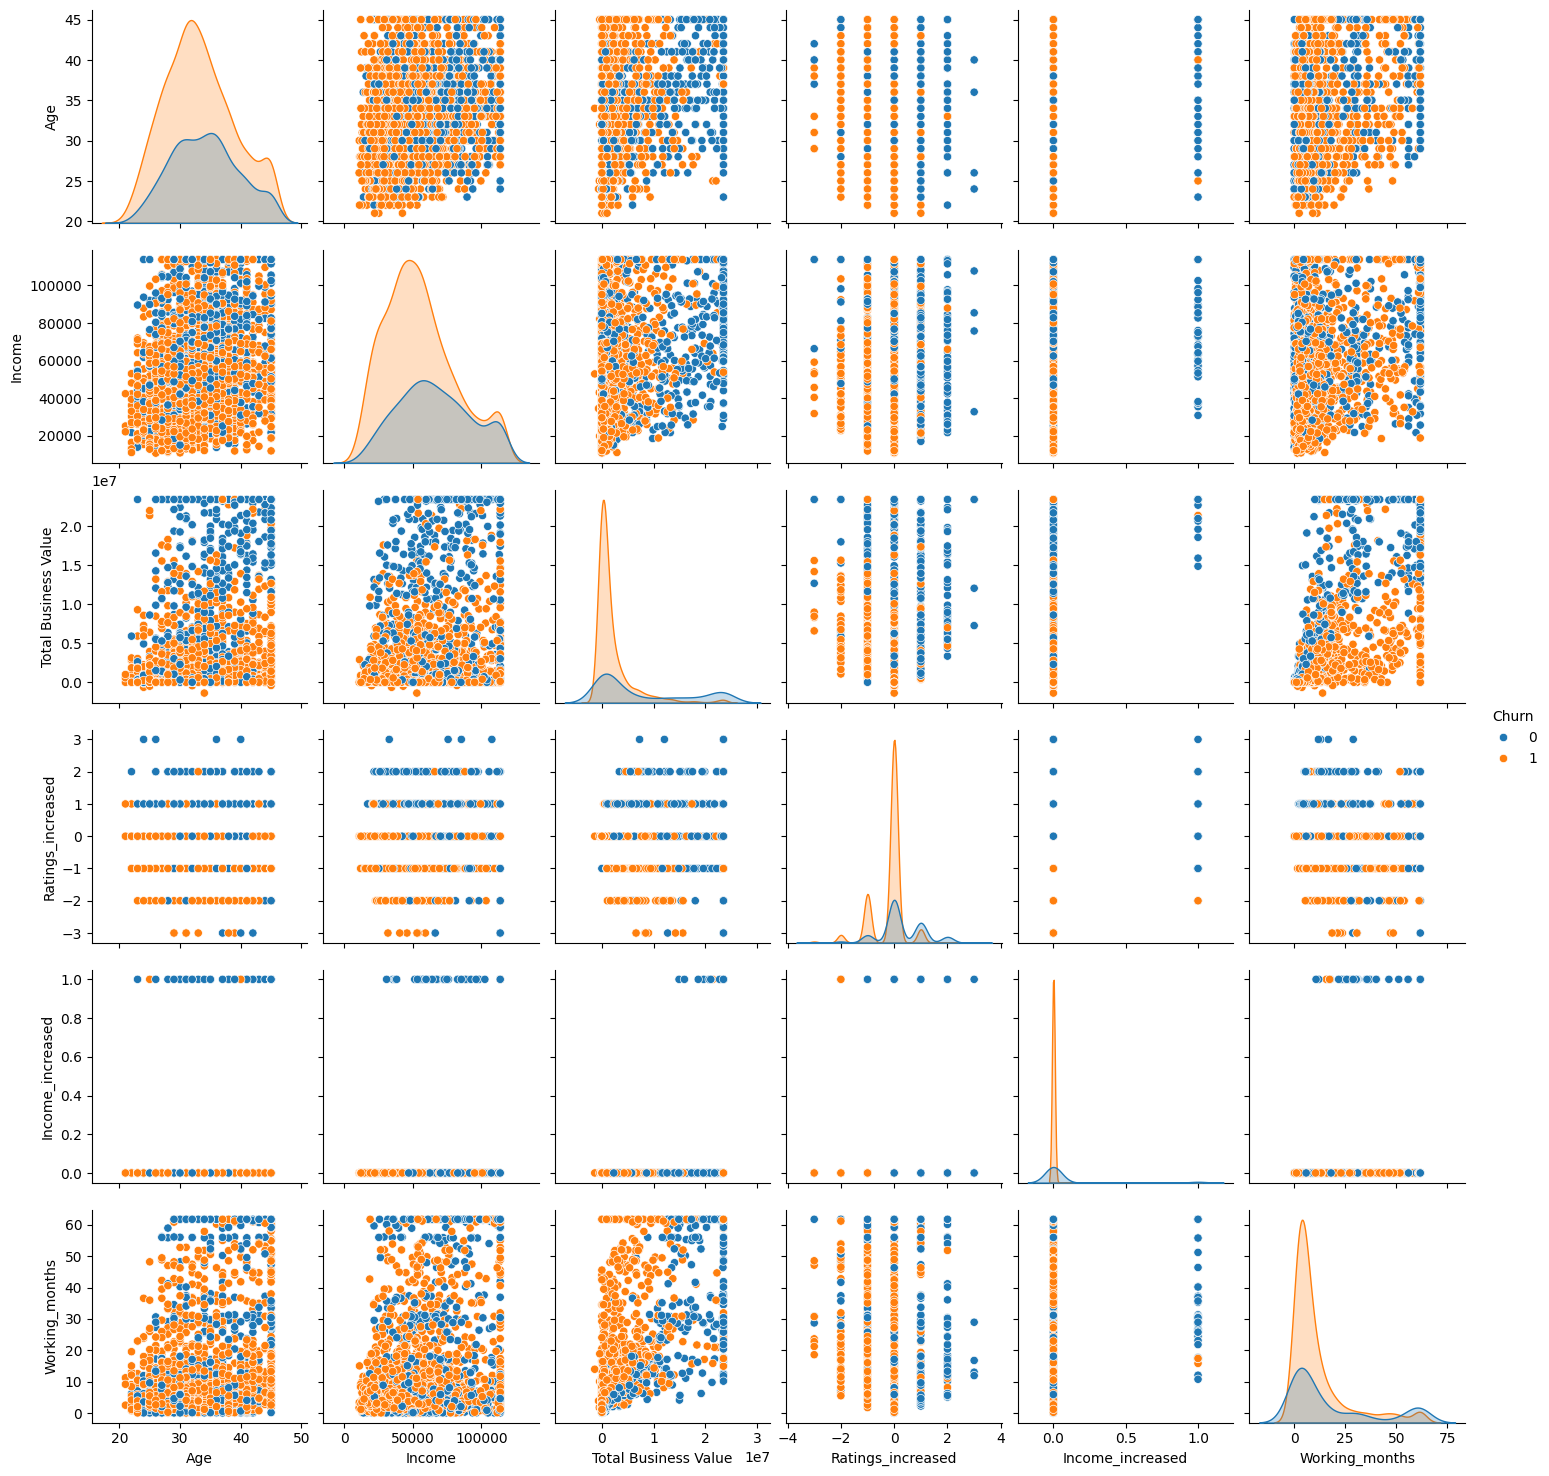

In [ ]:
columns=df_agg.columns.drop(['Driver_ID','LastWorkingDate'])
plt.figure(figsize=(14,17))
sns.pairplot(df_agg[columns],hue='Churn')
plt.show()

**Insights:**

- As age, income and total business value increased, drivers are likely to stay.
- If income,and total business increased, drivers stays.
- With increasein Working months,if total business increased, results in more retention too.  

## Preprocessing for Data Modelling

In [ ]:
# Dropping unncessary columns
df_agg.drop(columns=['Dateofjoining','LastWorkingDate','Driver_ID','Last_Reporting_month'],inplace=True)

In [ ]:
# Checking structure of final data
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   2381 non-null   float64 
 1   Gender                2381 non-null   category
 2   City                  2381 non-null   category
 3   Education_Level       2381 non-null   category
 4   Income                2381 non-null   int64   
 5   Joining Designation   2381 non-null   category
 6   Grade                 2381 non-null   category
 7   Total Business Value  2381 non-null   int64   
 8   Last_Quarter_Ratings  2381 non-null   category
 9   Ratings_increased     2381 non-null   int64   
 10  Income_increased      2381 non-null   int64   
 11  Churn                 2381 non-null   int64   
 12  Working_months        2381 non-null   float64 
dtypes: category(6), float64(2), int64(5)
memory usage: 146.4 KB


In [ ]:
df_agg[df_agg.select_dtypes('category').columns]

,Gender,City,Education_Level,Joining Designation,Grade,Last_Quarter_Ratings
0,0.0,C23,2,1,1,2
1,0.0,C7,2,2,2,1
2,0.0,C13,2,2,2,1
3,0.0,C9,0,1,1,1
4,1.0,C11,1,3,3,2
...,...,...,...,...,...,...
2376,0.0,C24,0,2,3,4
2377,1.0,C9,0,1,1,1
2378,0.0,C19,0,2,2,1
2379,1.0,C20,2,1,1,1


In [ ]:
# Separating features and label
X=df_agg.drop('Churn',axis=1)
y=df_agg['Churn']

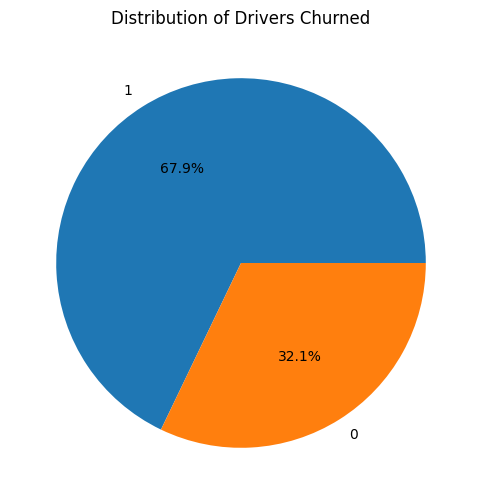

In [ ]:
# Checking data balance
y.value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.ylabel('')
plt.title('Distribution of Drivers Churned')
plt.show()

In [ ]:
# @title Balancing, encoding and standardising training data

from imblearn.over_sampling import SMOTE

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

te=TargetEncoder()
X_train['City'] = te.fit_transform(X_train['City'], y_train)
X_test['City'] = te.transform(X_test['City'])

smote=SMOTE()
X_train_bal,y_train_bal=smote.fit_resample(X_train,y_train)

sc=StandardScaler()
X_train_bal_scaled=sc.fit_transform(X_train_bal)
X_test_scaled=sc.transform(X_test)

print('Training dataset size,:',X_train.shape)
print('Testing dataset size,:', X_test.shape)

Training dataset size,: (1904, 12)
Testing dataset size,: (477, 12)


Training dataset size before balancing:, (1904, 12)
Training dataset size after balancing:, (2584, 12)


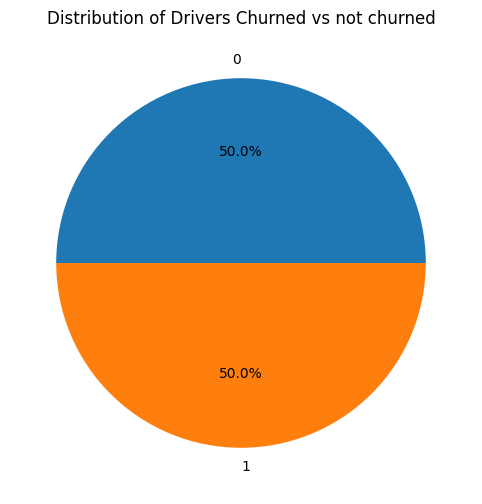

In [ ]:
print('Training dataset size before balancing:,',X_train.shape)
print('Training dataset size after balancing:,', X_train_bal.shape)
y_train_bal.value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.ylabel('')
plt.title('Distribution of Drivers Churned vs not churned')
plt.show()

## **Model Building**

### **Random Forest Classifier**

In [ ]:
# @title Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rfc = RandomForestClassifier(random_state=42)

sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [3, 4, 5, 6, 7, 8],
    "n_estimators": [50, 100, 150],
    "ccp_alpha": [0.001, 0.01, 0.1]
}

gridcv = GridSearchCV(
    estimator=rfc,
    param_grid=params,
    n_jobs=-1,
    cv=sf,
    verbose=4,
    scoring='f1'
)

gridcv.fit(X_train_bal_scaled, y_train_bal)

model1 = gridcv.best_estimator_

print("Best Params for Random Forest: ", gridcv.best_params_)
print("Best Score: ", gridcv.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params for Random Forest:  {'ccp_alpha': 0.001, 'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 150}
Best Score:  0.8736774302659402


In [ ]:
rfc=RandomForestClassifier(ccp_alpha= 0.001, max_depth=  8, min_samples_split= 8, n_estimators= 50,random_state=42)
rfc.fit(X_train_bal_scaled,y_train_bal)
y_pred=rfc.predict(X_test_scaled)
print('Accuracy Score for training data:',rfc.score(X_train_bal_scaled,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))
print(f'Recall Score is: {recall_score(y_test,y_pred)}')
print(f'Precision Score is: {precision_score(y_test,y_pred)}')
print(f'F1 Score is: {f1_score(y_test,y_pred)}\n\n')
print(f'\t\t\tClassification Report\n\n{classification_report(y_test, y_pred)}')

Accuracy Score for training data: 0.8889318885448917
Accuracy Score for test data: 0.8679245283018868
Recall Score is: 0.9351851851851852
Precision Score is: 0.8782608695652174
F1 Score is: 0.905829596412556


			Classification Report

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       153
           1       0.88      0.94      0.91       324

    accuracy                           0.87       477
   macro avg       0.86      0.83      0.84       477
weighted avg       0.87      0.87      0.87       477



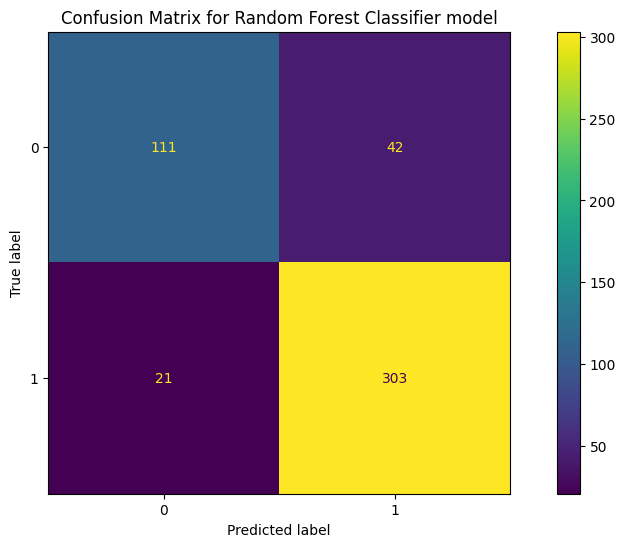

In [ ]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix for Random Forest Classifier model')

plt.show()

**Insights:**

- Accuracy Score for training data: 0.8862229102167183
- Accuracy Score for test data: 0.859538784067086
- Recall Score is: 0.9228395061728395
- Precision Score is: 0.8768328445747801
- F1 Score is: 0.8992481203007519
- True Positive: 299
- False Positive: 42
- True Negative: 111
- False Negative: 25


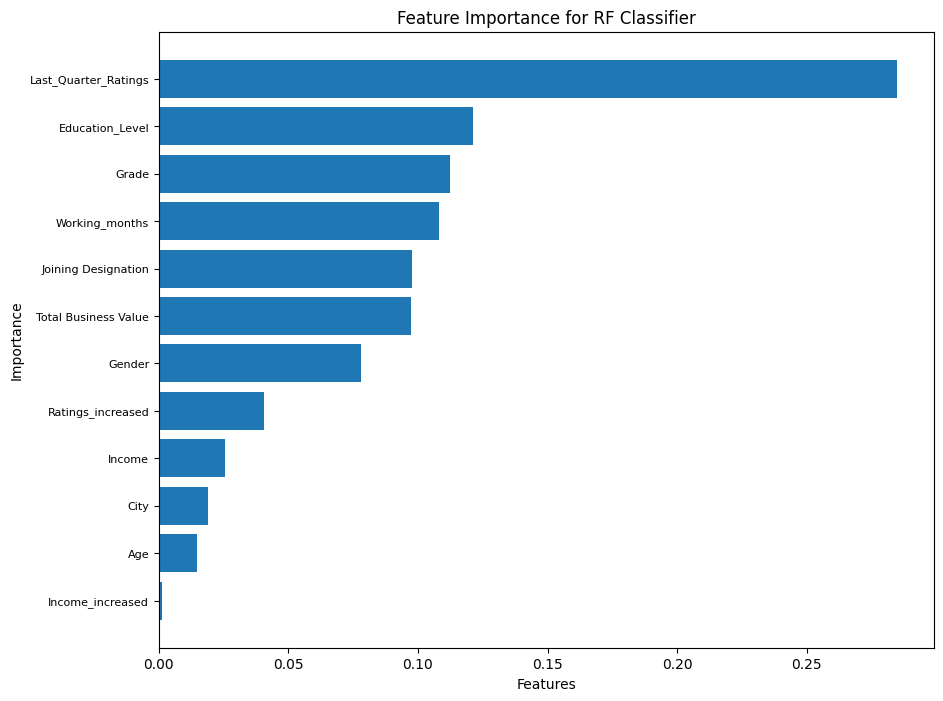

In [ ]:
# @title Feature Importance
feature_names = X_train.columns
f_imp=model1.feature_importances_
sorted_idx = np.argsort(f_imp)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = f_imp[sorted_idx]

plt.figure(figsize=(10,8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names,size=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.gca().invert_yaxis()
plt.title('Feature Importance for RF Classifier')
plt.show()

**Insights:**

- The most important features are Last Quarter Rating, Education Level, Grade
- The least impotant features are City, Age, Income increase

### ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:

- FPR=(FP)/(FP+TN)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

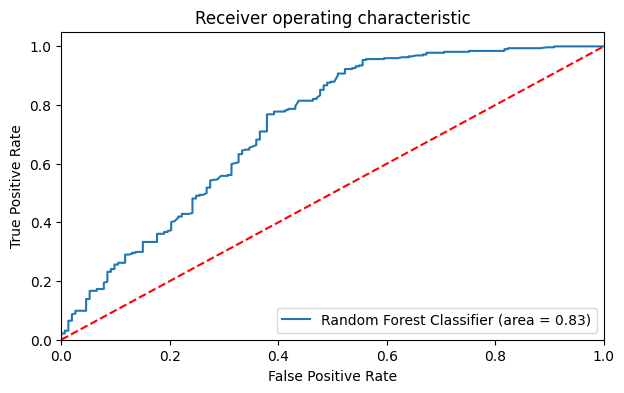

In [ ]:
# using ROC-AUC for Random Forest model
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,model1.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,4))
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Insights:**

An AU-ROC value of 0.83 suggests that, on average, the model has a good ability to distinguish between the positive and negative classes, but there is room for improvement.

### **Gradient Boosing Classfier**

In [ ]:
# @title Hyperparameter Tuning

params={
    'n_estimators': [50, 100, 150, 200],
    'max_depth' : [2,3,4],
    'loss': ['log_loss','exponential'],
    'learning_rate' : [0.1, 0.2, 0.3],
    'subsample' : [0.1, 0.2, 0.5, 0.8, 1],
}
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gbdt=GradientBoostingClassifier()
gridvc=GridSearchCV(estimator=gbdt, param_grid=params, cv=sf, n_jobs=-1, verbose=2, scoring='f1')

gridcv.fit(X_train_bal_scaled, y_train_bal)
gbdt_model=gridcv.best_estimator_
print(gridcv.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'ccp_alpha': 0.001, 'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 150}


In [ ]:
gbdt_model.fit(X_train_bal_scaled,y_train_bal)
y_pred=gbdt_model.predict(X_test_scaled)
print('Accuracy Score for training data:',gbdt_model.score(X_train_bal_scaled,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))
print(f'Recall Score is: {recall_score(y_test,y_pred)}')
print(f'Precision Score is: {precision_score(y_test,y_pred)}')
print(f'F1 Score is: {f1_score(y_test,y_pred)}\n\n')
print(f'\t\t\tClassification Report\n\n{classification_report(y_test, y_pred)}')

Accuracy Score for training data: 0.8908668730650154
Accuracy Score for test data: 0.8658280922431866
Recall Score is: 0.9320987654320988
Precision Score is: 0.877906976744186
F1 Score is: 0.9041916167664671


			Classification Report

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       153
           1       0.88      0.93      0.90       324

    accuracy                           0.87       477
   macro avg       0.86      0.83      0.84       477
weighted avg       0.86      0.87      0.86       477



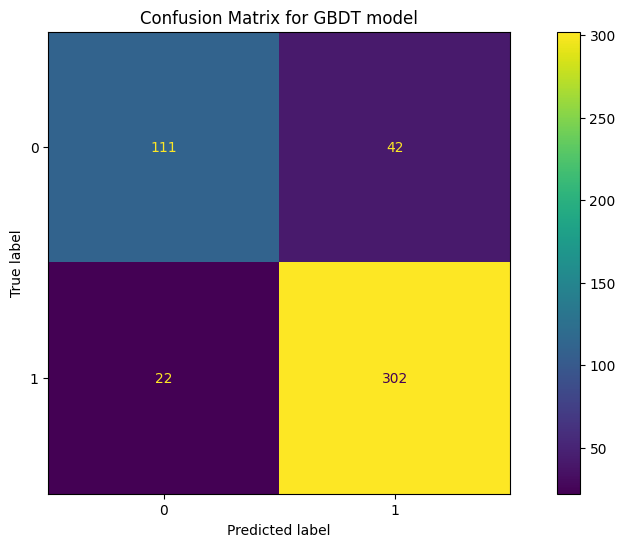

In [ ]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbdt_model.classes_).plot()
plt.title('Confusion Matrix for GBDT model')
plt.show()

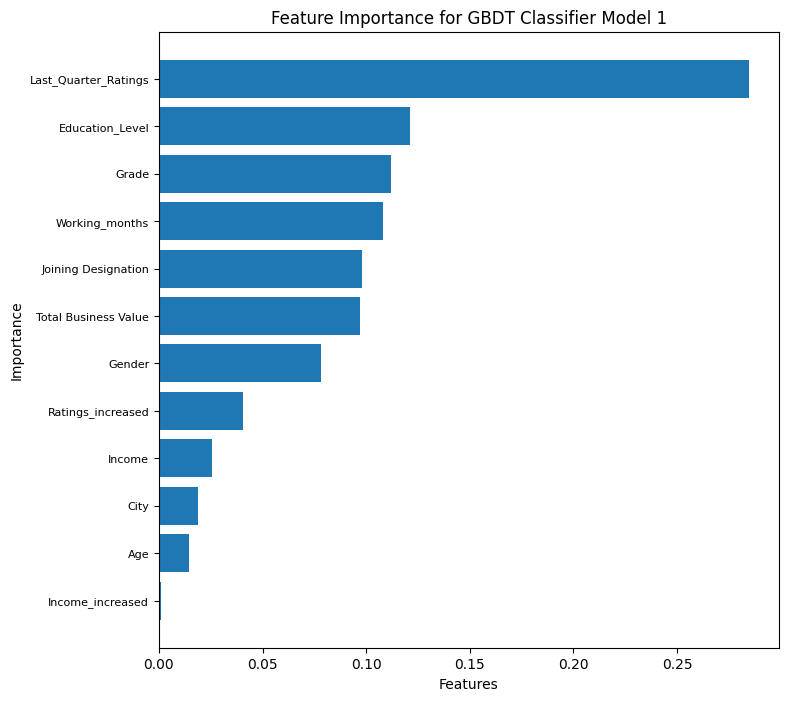

In [ ]:
# @title Feature Importance
feature_names = X_train.columns
f_imp=gbdt_model.feature_importances_
sorted_idx = np.argsort(f_imp)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = f_imp[sorted_idx]

plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names,size=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.gca().invert_yaxis()
plt.title('Feature Importance for GBDT Classifier Model')
plt.show()

**Insights:**

- The most important features are Last Quarter Rating, Education Level, Grade
- The least impotant features are City, Age, Income increase

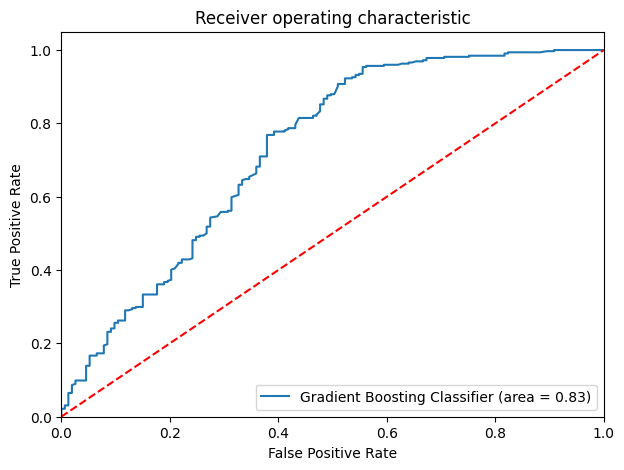

In [ ]:
# @title ROC-AUC
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,gbdt_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Insights:**

An AU-ROC value of 0.83 suggests that, on average, the model has a good ability to distinguish between the positive and negative classes, but there is room for improvement.

### **XGBT**

In [ ]:
# @title Hyerparameter Tuning

params={
    'n_estimators': [50, 100, 150, 200],
    'max_depth' : [2,3,4,5],
    'loss': ['log_loss','exponential'],
    'learning_rate' : [0.1, 0.2, 0.3],
    'subsample' : [0.1, 0.2, 0.5, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
sf=StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
xgb=XGBClassifier()
gridcv=GridSearchCV(estimator=xgb, cv=sf, n_jobs=-1, verbose=2, param_grid=params, scoring='f1')

gridcv.fit(X_train_bal_scaled, y_train_bal)
xgb_model=gridcv.best_estimator_

print("Best parameters are: ",gridcv.best_params_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters are:  {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 4, 'n_estimators': 100, 'subsample': 1}


In [ ]:
xgb_model.fit(X_train_bal_scaled,y_train_bal)
y_pred=xgb_model.predict(X_test_scaled)
print('Accuracy score for training data:',xgb_model.score(X_train_bal_scaled,y_train_bal))
print('Accuracy Score for testing data:',accuracy_score(y_test,y_pred))
print(f'Recall Score is: {recall_score(y_test,y_pred)}')
print(f'Precision Score is: {precision_score(y_test,y_pred)}')
print(f'F1 Score is: {f1_score(y_test,y_pred)}\n\n')
print(f'\t\t\tClassification Report\n\n{classification_report(y_test, y_pred)}')

Accuracy score for training data: 0.9369195046439629
Accuracy Score for testing data: 0.8511530398322851
Recall Score is: 0.9104938271604939
Precision Score is: 0.8753709198813057
F1 Score is: 0.8925869894099848


			Classification Report

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       153
           1       0.88      0.91      0.89       324

    accuracy                           0.85       477
   macro avg       0.83      0.82      0.83       477
weighted avg       0.85      0.85      0.85       477



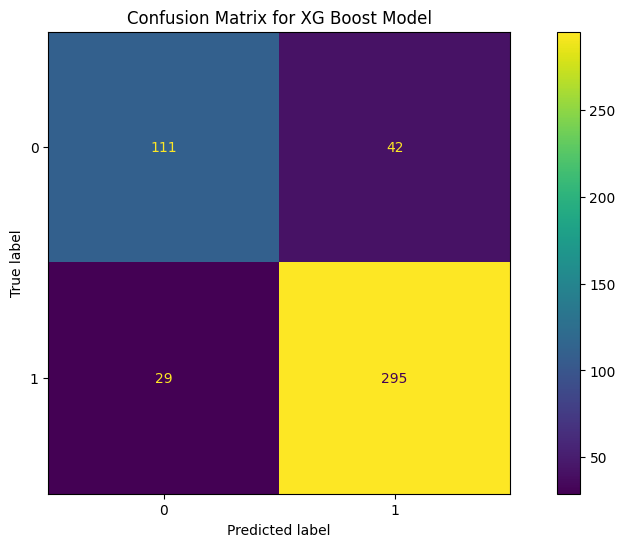

In [ ]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_).plot()
plt.title('Confusion Matrix for XG Boost Model')
plt.show()

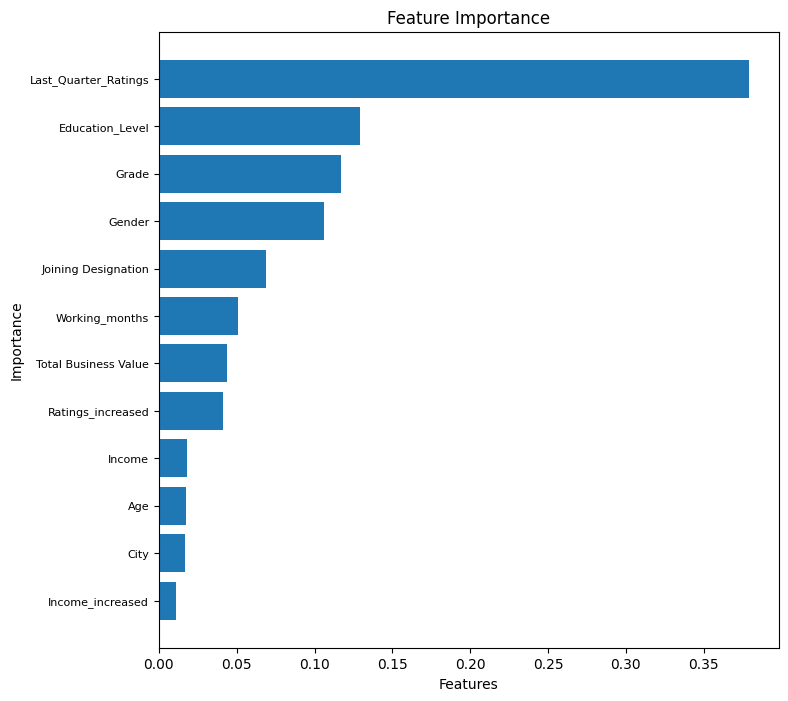

In [ ]:
# @title Feature Importance
feature_names = X_train.columns
f_imp=xgb_model.feature_importances_
sorted_idx = np.argsort(f_imp)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = f_imp[sorted_idx]

plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names,size=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

**Insights:**

- The most important features are Last Quarter Rating, Education Level, Grade
- The least impotant features are City, Age, Income increase

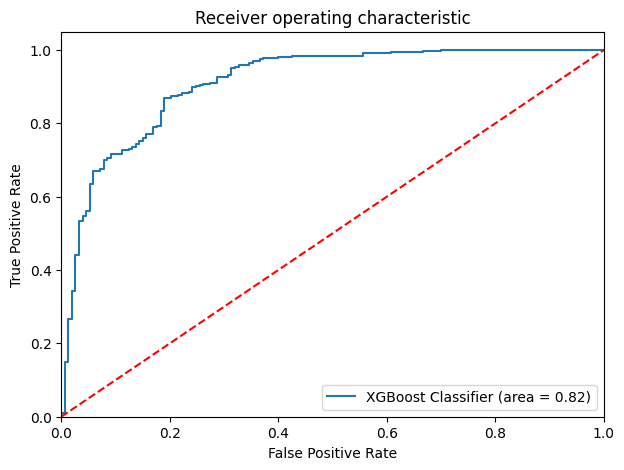

In [ ]:
# @title ROC-AUC
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,xgb_model.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Insights:**

An AU-ROC value of 0.82 suggests that, on average, the model has a good ability to distinguish between the positive and negative classes, but there is room for improvement.


### **Light GBM**

In [ ]:
# @title Hyerparameter Tuning

params={
    'n_estimators': [50, 100, 150, 200],
    'max_depth' : [2,3,4],
    'learning_rate' : [0.1, 0.2, 0.3],
    'subsample' : [0.1, 0.2, 0.5, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
sf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
lgbm=LGBMClassifier(random_state=42, objective='binary')
gridcv=GridSearchCV(estimator=lgbm, cv=sf, n_jobs=-1, verbose=2, param_grid=params, scoring='f1')

gridcv.fit(X_train_bal_scaled, y_train_bal)
lgbm_model=gridcv.best_estimator_

print("Best parameters are: ",gridcv.best_params_)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
lgbm_model.fit(X_train_bal_scaled,y_train_bal)
y_pred=lgbm_model.predict(X_test_scaled)
print('Accuracy score for training data:',lgbm_model.score(X_train_bal_scaled,y_train_bal))
print('Accuracy Score for testing data:',accuracy_score(y_test,y_pred))
print(f'Recall Score is: {recall_score(y_test,y_pred)}')
print(f'Precision Score is: {precision_score(y_test,y_pred)}')
print(f'F1 Score is: {f1_score(y_test,y_pred)}\n\n')
print(f'\t\t\tClassification Report\n\n{classification_report(y_test, y_pred)}')

[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

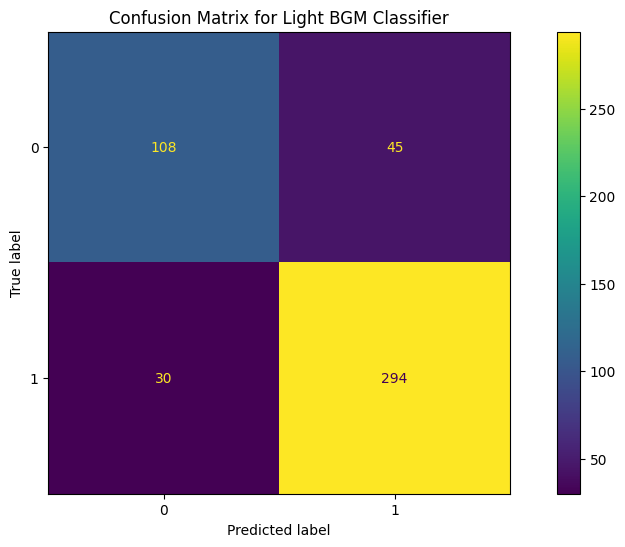

In [ ]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_model.classes_).plot()
plt.title('Confusion Matrix for Light BGM Classifier')
plt.show()

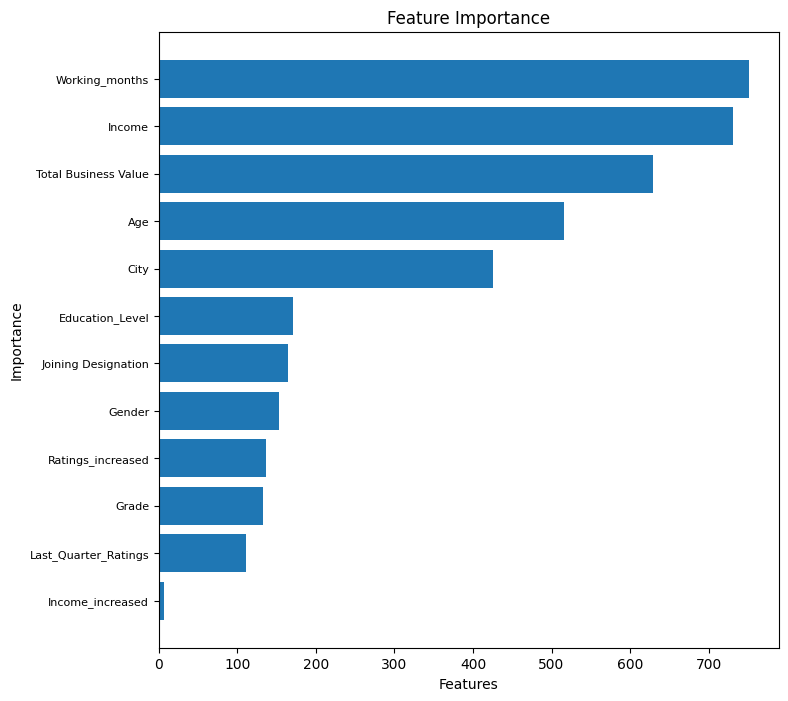

In [ ]:
# @title Feature Importance
feature_names = X_train.columns
f_imp=lgbm_model.feature_importances_
sorted_idx = np.argsort(f_imp)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = f_imp[sorted_idx]

plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names,size=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

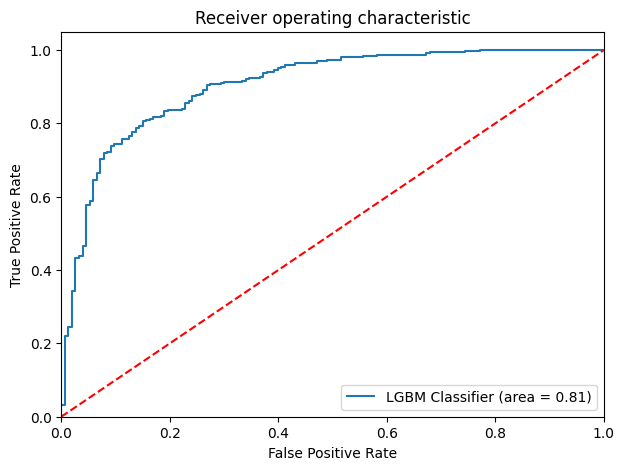

In [ ]:
# @title ROC-AUC
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,lgbm_model.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='LGBM Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Insights:**

An AU-ROC value of 0.82 suggests that, on average, the model has a good ability to distinguish between the positive and negative classes, but there is room for improvement.

## **MODEL results**
Best model turns out to be GBDT having 0.86 testing accuracy with 0.93 recall score and AUC is 0.83.
The most important feature as per most of the models is **Last Quarterly Ratings** which is same for this model too.

Please find the details of the model below:
- Accuracy Score for training data: 0.8908668730650154
- Accuracy Score for test data: 0.8658280922431866
- Recall Score is: 0.9320987654320988
- Precision Score is: 0.877906976744186
- F1 Score is: 0.9041916167664671

## **Overall Insights**

1. **High Churn and Business Impact**: With nearly 68% of drivers churning, the business is heavily impacted by the loss of trained and experienced drivers. This churn correlates with lower business value, reduced productivity, and significant retraining costs.

2. **Tenure and Performance Link**: Short-tenured drivers tend to churn at a higher rate. Performance ratings and business value positively correlate with tenure, indicating that longer-serving drivers are more valuable and likely to stay.

3. **Income Stagnation as a Churn Factor**: Since most drivers haven't received income increases, dissatisfaction with compensation may be a driving factor for churn, especially among high-performing drivers who might leave for better-paying opportunities.

4. **City-Specific Churn Patterns**: Some cities, such as C20, C15, and C26, exhibit significantly higher churn, suggesting potential operational or satisfaction issues. Conversely, cities like C5, C19, and C29 have more balanced churn, implying favorable conditions or better alignment with driver needs.

5. **Performance Ratings and Retention**: Drivers with higher performance ratings tend to stay longer, while those with lower ratings are more likely to churn. This may highlight a need for improved engagement or upskilling efforts for low-rated drivers.
 - Ratings may be having some impact socially or financially as high rating employees retention rate is higher than others.

6. **Churn Rate Comparisons**: The 68% churn rate observed here is significantly higher than the typical attrition rate in the gig economy, which generally ranges from 20-50% annually. This elevated rate suggests severe issues with either job satisfaction, career growth, or competitive pay, implying the need for immediate retention strategies.

7. **Income and Cost of Living Correlation**: Higher churn in cities like C20, C15, and C26 might be tied to higher living costs or better job alternatives available in these areas. In major cities, drivers may expect more competitive wages, benefits, and flexibility; thus, inadequate pay or benefits in these high-cost locations can drive attrition.

8. **Joining Date Patterns**: Drivers joining from 2018 onward show higher churn, which may reflect changes in the gig economy post-2017, including intensified competition from similar companies, increased regulatory scrutiny, and shifts in driver expectations around job flexibility and compensation.

9. **Younger Workforce Expectations**: Younger drivers are more likely to churn, aligning with broader trends where younger employees seek career advancement, flexibility, and fair compensation. They are also more likely to switch jobs for even minor improvements in work-life balance or pay.

10. **Attrition and Job Satisfaction in Gig Roles**: In gig work, research shows that lack of benefits, inconsistent income, and limited growth opportunities often contribute to high churn. Since most drivers have low to stagnant income and minimal performance-based incentives, creating a path for rewards or upskilling could mitigate these effects.

These insights indicate that addressing tenure, income growth, and city-specific issues could improve retention rates.

## **Recommendations**

1. **Increase Pay in High-Churn Cities**: For cities like C20 and C15, consider
locality-based compensation to align with the cost of living and driver expectations. Competitive pay here could reduce attrition driven by economic pressures.
2. **Cities based Analysis**: For cities with high attrition, conducting qualitative analysis (like driver feedback) could reveal actionable insights, such as adjusting incentives, revising working conditions, or addressing specific city-based challenges to improve retention.
3. **Incentivize Tenure**: Introduce monthly bonuses or benefits that increase with tenure, encouraging drivers to stay longer. An annual pay increase, or even incremental raises every six months, could motivate drivers to commit longer-term.
4. **Flexible Scheduling**: Implement flexible shift planning or more control over work hours, as younger employees prioritize flexibility.
5. **Career Pathway Programs**: Develop basic skill-building or certification programs, enhancing long-term job satisfaction and loyalty among younger drivers. Programs might include safe-driving certifications, business skills, or financial literacy workshops.
6. **Introduce Health & Wellness Benefits**: With high competition in the gig economy, providing drivers with basic health insurance, wellness perks (like gym memberships), or mental health support can set the company apart from competitors. Highlighting these benefits during recruitment can attract and retain drivers seeking stability.
7. **Offer Performance-Based Incentives**: Implement a tiered incentive structure based on performance metrics like customer ratings, safe-driving records, and consistent availability. This directly motivates high-performing drivers and may prevent them from switching to competitors for similar pay without these added perks.
8. **Establish Feedback Loops**: Introduce a system where drivers can provide regular feedback on operations, safety concerns, and customer interactions. Actively addressing driver feedback, especially from high-churn cities, helps identify local operational issues.
9. **Implement Career Counselling and Support**: Offer periodic one-on-one sessions with managers or mentors to help drivers address any challenges they face. Clear communication can uncover issues like operational inefficiencies or dissatisfaction with schedules, which often push drivers toward competitors.
10. **Implement Peer Recognition Programs**: Recognize top drivers each month with an “Employee of the Month” award or a similar recognition initiative. This fosters a sense of community and shared purpose, increasing job satisfaction and loyalty.
11. **Host Local Engagement Events**: Organize periodic, casual meet-ups or town-hall meetings for drivers to build camaraderie and engage with management. This can improve driver morale and foster a supportive work culture, helping to retain drivers.
12. **Early Churn Prediction Models**: Deploying models to identify at-risk drivers and proactively reaching out to these drivers with tailored retention offers—such as schedule adjustments or small financial incentives—can reduce churn.
13. **Benchmark Against Competitors**: Regularly evaluate competitor offerings to stay aware of industry standards and avoid losing drivers to better benefits, pay structures, or operational efficiency. Use this data to continuously adjust and improve your retention strategies.
14. **Increase Quarterly Ratings**: Employees who experience an increase in their quarterly ratings are less likely to leave the company. Implementing measures to boost quarterly ratings could help in reducing churn.
15. **Reward System for Customer Ratings**: The company should introduce a reward system for customers who provide feedback and rate drivers. This initiative can incentivize customers to participate in the rating process, leading to more comprehensive feedback and improved driver performance.
16. **Identify Reasons for Low Ratings**: Among the 2,381 employees, 1,744 individuals had their last quarterly rating as 1. Identifying the reasons behind this low rating and implementing corrective measures is crucial for employee retention and overall performance improvement.
17. **Intervention for Stagnant Ratings**: It is concerning that the quarterly rating has not increased for 2,076 employees out of 2,381. This signals a need for closer monitoring and intervention to address any underlying issues affecting employee satisfaction and performance.
18. **Predictive Features for Employee Turnover**: Key features such as Last Quarterly Rating, Total Business Value, Working Months and Ratings Increase should be closely tracked as predictors of employee turnover. Analyzing these features can help identify drivers at risk of leaving the company and implement targeted retention strategies.
19. **Gather More Data for Improved Model Performance**: The dataset imbalancing, affecting the recall score for target 0 (employees who stay in the company). Gathering more data can help address this issue and can improve the model's performance in identifying at-risk employees.
20. **GBDT Classifier Performance**: The GBDT Classifier achieves a recall score of 93% for employees who left the company. This indicates that the model is effectively identifying individuals at risk of turnover, providing valuable insights for retention efforts.

Each of these initiatives can help mitigate the competition threat while boosting driver satisfaction and company loyalty.
